In [1]:
import json
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import copy
from utils.utils import *
import pandas as pd
from scipy import stats

In [2]:
method_dict = {"MC": "Random Sample","random sample": "Random Sample", "surr ensemble": "ASE Class Score 0", "ASE": "ASE Class Score 0", "ASE_regression": "ASE Regression Score 0", 
               "ASE_all": "ASE All Score 0", "ASE_class_score_1": "ASE Class Score -1", "ASE_reg_score_1": "ASE Regression Score -1", "ASE_all_score_1": "ASE All Score -1", "MPL": "MPL"}
metric_dict = {'loss': 'Loss', 'mAP': 'mAP', "mAR_1000": "mAR"}
num_runs = 60
def add_entries(file):
    #columns=['active_test_type','sample_size','loss','mAP',"AP_50", "AP_75", "mAP_samll", "mAP_medium", "mAP_large", "mAR_1", "mAR_10", "mAR_1000", "mAR_small", "mAR_medium", "mAR_large"]
    with open(file, 'r') as openfile:
        json_object = json.load(openfile)
    df = None
    for key,value in json_object.items():
        if 'test_stats' in value.keys():
            del value['test_stats']
        value['active_test_type'] = method_dict[value['active_test_type']]
        # if value['sample_size'] < 180:
        #     continue
        temp_df = pd.DataFrame(value, index=[key])
        if df is None:
            df = temp_df
        else:
            df = df.append(temp_df,ignore_index=True)
    return df

In [3]:
# def plot_all_diff_precentage_figure(input_data, baseline_data, sample_nums, y_metric, x_label_name = "% of Acquired Images"):
#     data = copy.deepcopy(input_data)
#     f = plt.figure(figsize=(10, 8))
#     font_size = 25
#     data[y_metric] -= baseline_data[y_metric]
#     data[y_metric] = data[y_metric] / baseline_data[y_metric] * 100
#     data['sample_size'] = data['sample_size'] / sample_nums * 100
#     with sns.axes_style("darkgrid"):
#         sns.lineplot(data=data, \
#                      x='sample_size', y=y_metric, \
#                      hue='active_test_type', errorbar=('ci', 100), lw=3)
        
#     x_line = [data['sample_size'][0], data['sample_size'][data['sample_size'].shape[0]-1]]
#     y_line = [0, 0]
#     plt.plot(x_line, y_line, 'r')
#     plt.title("Active Testing", fontsize=30)
#     plt.xlabel(x_label_name, fontsize=font_size)# x轴标签
#     plt.ylabel("% Difference Rate to Full Test " + metric_dict[y_metric], fontsize=font_size)# y轴标签
#     # pic_name = scenario+'.png'
#     plt.legend(fontsize = 18)
#     plt.xticks(fontsize=20)
#     plt.yticks(fontsize=20)
#     plt.tight_layout()
#     #plt.ylim(-1600,-800)
#     #plt.savefig(pic_name,dpi=800)
#     plt.show()

def plot_all_diff_precentage_figure(input_data, baseline_data, sample_nums, y_metric, x_label_name = "% of Acquired Images", 
                                    pic_name = None):
    data = copy.deepcopy(input_data)
    f = plt.figure(figsize=(10, 8))
    font_size = 25
    data[y_metric] = abs(data[y_metric] - baseline_data[y_metric])
    data[y_metric] = data[y_metric] / baseline_data[y_metric] * 100
    data['sample_size'] = data['sample_size'] / sample_nums * 100
    with sns.axes_style("darkgrid"):
        sns.lineplot(data=data, \
                     x='sample_size', y=y_metric, \
                     hue='active_test_type', errorbar=('sd', 1), lw=3)
        
    # x_line = [data['sample_size'][0], data['sample_size'][data['sample_size'].shape[0]-1]]
    # y_line = [0, 0]
    # plt.plot(x_line, y_line, 'r')
    plt.title("Active Testing", fontsize=30)
    plt.xlabel(x_label_name, fontsize=font_size)# x轴标签
    plt.ylabel("% ER ", fontsize=font_size)# y轴标签
    # pic_name = scenario+'.png'
    plt.legend(fontsize = 18)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.tight_layout()
    # plt.style.use("fivethirtyeight")
    ax = plt.gca()
    ax.set_facecolor('none')
    #plt.ylim(-1600,-800)
    if pic_name is not None:
        plt.savefig(f"./figures/{pic_name}.pdf",dpi=800)
    plt.show()
    
def plot_diff_precentage_figure_comp(input_data, baseline_data, y_metric, x_label_name = "# of Acquired Images"):
    data = copy.deepcopy(input_data)
    f = plt.figure(figsize=(10, 8))
    font_size = 25
    data[y_metric] -= baseline_data[y_metric]
    data[y_metric] = data[y_metric] / baseline_data[y_metric]
    with sns.axes_style("darkgrid"):
        sns.lineplot(data=data, \
                     x='sample_size', y=y_metric, \
                     hue='active_test_type', errorbar=('ci', 100), lw=3)
    plt.title("Active Testing", fontsize=30)
    plt.xlabel(x_label_name, fontsize=font_size)# x轴标签
    plt.ylabel(metric_dict[y_metric] + " Diff %", fontsize=font_size)# y轴标签
    plt.legend(fontsize = 18)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.tight_layout()
    plt.show()

def read_baseline_data(data_path):
    with open(data_path, 'r') as openfile:
        none_swin_data = json.load(openfile)
    return none_swin_data["0"]

def print_mean_std(path, test_whole_data):
    global temp_list
    data = add_entries(path)
    data = data['loss'].values
    mean = ((np.abs(data - test_whole_data) / test_whole_data).mean()) * 100
    std = ((np.abs(data - test_whole_data) / test_whole_data).std()) * 100
    print(f"{path}: mean {mean:.2f}, std {std:.2f}")
    temp_list.append(mean)
    temp_list.append(std)

def get_mean_std(path, test_whole_data):
    data = add_entries(path)
    data = data['loss'].values
    mean = ((np.abs(data - test_whole_data) / test_whole_data).mean()) * 100
    std = ((np.abs(data - test_whole_data) / test_whole_data).std()) * 100
    return mean, std

def show_significance_value(model_dataset, steps, image_path, result_path, level):
    if model_dataset[-1] == "0":
        model_origin_folder = model_dataset[:-3]
    else:
        model_origin_folder = model_dataset
    base_path = f"./pro_data/{model_origin_folder}/val/"
    sample_size_threshold = np_read(base_path + image_path).shape[0]
    result_json_path = f"./results/{store_folder}/{model_dataset}/{result_path}/"
    test_whole_data = read_baseline_data(result_json_path + "None.json")['loss']
    rs_mean, rs_std = get_mean_std(result_json_path + "random_sample_3_runs.json", test_whole_data)
    vit_mean, vit_std = get_mean_std(result_json_path + f"ViT_{level}_runs_{steps}.json", test_whole_data)
    ase_mean, ase_std = get_mean_std(result_json_path + "ASE_runs.json", test_whole_data)
    at_mean, at_std = get_mean_std(result_json_path + "AT_runs.json", test_whole_data)
    print(f"{model_dataset}:")
    print(f"VIT:RS:  {stats.ttest_ind_from_stats(vit_mean, vit_std, num_runs, rs_mean, rs_std, num_runs)}")
    print(f"VIT:ASE:  {stats.ttest_ind_from_stats(vit_mean, vit_std, num_runs, ase_mean, ase_std, num_runs)}")
    print(f"VIT:AT:  {stats.ttest_ind_from_stats(vit_mean, vit_std, num_runs, at_mean, at_std, num_runs)}")
    
def show_results(model_dataset, steps, image_path, result_path, level):
    if model_dataset[-1] == "0":
        model_origin_folder = model_dataset[:-3]
    else:
        model_origin_folder = model_dataset
    base_path = f"./pro_data/{model_origin_folder}/val/"
    sample_size_threshold = np_read(base_path + image_path).shape[0]
    result_json_path = f"./results/{store_folder}/{model_dataset}/{result_path}/"
    true_loss_estimation_path = result_json_path + "None.json"
    test_whole_data = read_baseline_data(true_loss_estimation_path)
    results = add_entries(result_json_path + "random_sample_3_runs.json")
    results =  results.append(add_entries(result_json_path + f"ViT_{level}_runs_{steps}.json"),ignore_index=True)
    results =  results.append(add_entries(result_json_path + "ASE_runs.json"),ignore_index=True)
    results =  results.append(add_entries(result_json_path + "AT_runs.json"),ignore_index=True)
    plot_all_diff_precentage_figure(results, test_whole_data, sample_size_threshold, "loss", x_label_name = "% of Acquired Labels")
    
def show_all_methods_mean_std(model_dataset, steps, image_path, result_path, level):
    global temp_list, result_pd
    if model_dataset[-1] == "0":
        model_origin_folder = model_dataset[:-3]
    else:
        model_origin_folder = model_dataset
    base_path = f"./pro_data/{model_origin_folder}/val/"
    sample_size_threshold = np_read(base_path + image_path).shape[0]
    result_json_path = f"./results/{store_folder}/{model_dataset}/{result_path}/"
    test_whole_data = read_baseline_data(result_json_path + "None.json")['loss']
    temp_list = []
    print_mean_std(result_json_path + "random_sample_3_runs.json", test_whole_data)
    print_mean_std(result_json_path + f"ViT_{level}_runs_{steps}.json", test_whole_data)
    print_mean_std(result_json_path + "ASE_runs.json", test_whole_data)
    print_mean_std(result_json_path + "AT_runs.json", test_whole_data)
    result_pd[model_dataset] = copy.deepcopy(temp_list)

## Object Detetcion Box based

In [4]:
method_dict = {"random sample": "Random Sample", "ViT": "Our ViTAL"}
def show_det_box_results(steps, pic_name=None):
    base_path = "../../active_testing_det/orkspace/DINO/"
    sample_size_threshold = np_read(base_path + "data/5_scale_31/val/feature_pre_data/annotation.npy").shape[0]
    result_json_path = base_path + f"results/active_test_box_level_VIT/"
    true_loss_estimation_path = result_json_path + "None_R50_31.json"
    test_whole_data = read_baseline_data(true_loss_estimation_path)
    results = add_entries(result_json_path + "random_sample_R50_31_10_runs.json")
    results =  results.append(add_entries(result_json_path + f"ViT_runs_{steps}.json"),ignore_index=True)
    plot_all_diff_precentage_figure(results, test_whole_data, sample_size_threshold, "loss", x_label_name = "% of Acquired Labels", pic_name = pic_name)

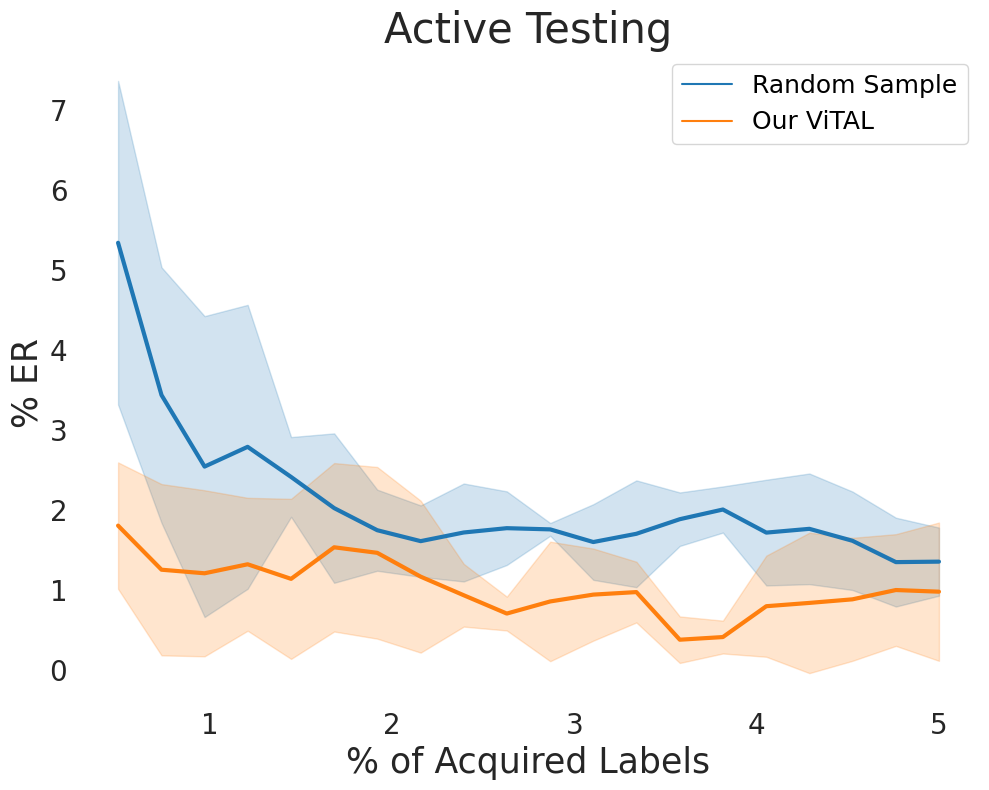

In [6]:
# show_det_box_results(30000, pic_name = "Det_Box")
show_det_box_results(30000)

## Image based

In [64]:
# PSPNet_VOC, UNet_COCO10k, UNet_VOC, DeepLab_VOC, FCN_VOC, SEGNet_VOC,
method_dict = {"random sample": "Random Sample", "ViT all": "our ViT", "ASE image":"ASE", "AT image": "ATS"}
store_folder = "runs_3"
def show_image_results(model_dataset, steps = 10000):
    show_results(model_dataset, steps, "image_true_losses.npy", "image_based_active_testing", "all")
    
result_pd = {}
temp_list = []
def show_image_all_methods_mean_std(model_dataset, steps = 10000):
    show_all_methods_mean_std(model_dataset, steps, "image_true_losses.npy", "image_based_active_testing", "all")
    
def show_image_significance_value(model_dataset, steps = 10000):
    show_significance_value(model_dataset, steps, "image_true_losses.npy", "image_based_active_testing", "all")

In [67]:
show_image_all_methods_mean_std("PSPNet_COCO", 30000)
show_image_all_methods_mean_std("UNet_COCO", 20000)
show_image_all_methods_mean_std("SEGNet_COCO", 5000)
show_image_all_methods_mean_std("FCN_COCO", 10000)

show_image_all_methods_mean_std("PSPNet_ADE20K", 15000)
show_image_all_methods_mean_std("UNet_ADE20K", 15000)
show_image_all_methods_mean_std("SEGNet_ADE20K", 20000)
show_image_all_methods_mean_std("FCN_ADE20K", 55000)
df = pd.DataFrame(result_pd)
df.to_excel('excel/image_COCO.xlsx', index=False)

show_image_all_methods_mean_std("PSPNet_COCO_40", 5000)
show_image_all_methods_mean_std("PSPNet_ADE20K_70", 5000)
show_image_all_methods_mean_std("SEGNet_COCO_90", 20000)
show_image_all_methods_mean_std("PSPNet_ADE20K_40", 5000)
show_image_all_methods_mean_std("FCN_ADE20K_90", 10000)

./results/runs_3/PSPNet_COCO/image_based_active_testing/random_sample_3_runs.json: mean 19.24, std 11.62
./results/runs_3/PSPNet_COCO/image_based_active_testing/ViT_all_runs_30000.json: mean 15.32, std 9.58
./results/runs_3/PSPNet_COCO/image_based_active_testing/ASE_runs.json: mean 10.29, std 5.64
./results/runs_3/PSPNet_COCO/image_based_active_testing/AT_runs.json: mean 20.33, std 8.92
./results/runs_3/UNet_COCO/image_based_active_testing/random_sample_3_runs.json: mean 7.30, std 4.17
./results/runs_3/UNet_COCO/image_based_active_testing/ViT_all_runs_20000.json: mean 4.76, std 4.60
./results/runs_3/UNet_COCO/image_based_active_testing/ASE_runs.json: mean 5.18, std 3.98
./results/runs_3/UNet_COCO/image_based_active_testing/AT_runs.json: mean 5.38, std 3.17
./results/runs_3/SEGNet_COCO/image_based_active_testing/random_sample_3_runs.json: mean 12.87, std 7.69
./results/runs_3/SEGNet_COCO/image_based_active_testing/ViT_all_runs_5000.json: mean 5.46, std 4.60
./results/runs_3/SEGNet_COCO/

In [66]:
data_type = "PSPNet_COCO"
show_image_all_methods_mean_std(data_type, 5000)
show_image_all_methods_mean_std(data_type, 10000)
show_image_all_methods_mean_std(data_type, 15000)
show_image_all_methods_mean_std(data_type, 20000)
show_image_all_methods_mean_std(data_type, 25000)
show_image_all_methods_mean_std(data_type, 30000)
show_image_all_methods_mean_std(data_type, 35000)
show_image_all_methods_mean_std(data_type, 40000)
show_image_all_methods_mean_std(data_type, 45000)
# show_image_all_methods_mean_std(data_type, 50000)
# show_image_all_methods_mean_std(data_type, 55000)
# show_image_all_methods_mean_std(data_type, 60000)
# show_image_all_methods_mean_std(data_type, 65000)
# show_image_all_methods_mean_std(data_type, 70000)
# show_image_all_methods_mean_std(data_type, 75000)
# show_image_all_methods_mean_std(data_type, 80000)
# show_image_all_methods_mean_std(data_type, 85000)
# show_image_all_methods_mean_std(data_type, 90000)
# show_image_all_methods_mean_std(data_type, 95000)
# show_image_all_methods_mean_std(data_type, 100000)

./results/runs_3/PSPNet_COCO/image_based_active_testing/random_sample_3_runs.json: mean 19.24, std 11.62
./results/runs_3/PSPNet_COCO/image_based_active_testing/ViT_all_runs_5000.json: mean 20.27, std 12.65
./results/runs_3/PSPNet_COCO/image_based_active_testing/ASE_runs.json: mean 10.29, std 5.64
./results/runs_3/PSPNet_COCO/image_based_active_testing/AT_runs.json: mean 20.33, std 8.92
./results/runs_3/PSPNet_COCO/image_based_active_testing/random_sample_3_runs.json: mean 19.24, std 11.62
./results/runs_3/PSPNet_COCO/image_based_active_testing/ViT_all_runs_10000.json: mean 23.88, std 13.35
./results/runs_3/PSPNet_COCO/image_based_active_testing/ASE_runs.json: mean 10.29, std 5.64
./results/runs_3/PSPNet_COCO/image_based_active_testing/AT_runs.json: mean 20.33, std 8.92
./results/runs_3/PSPNet_COCO/image_based_active_testing/random_sample_3_runs.json: mean 19.24, std 11.62
./results/runs_3/PSPNet_COCO/image_based_active_testing/ViT_all_runs_15000.json: mean 21.94, std 11.24
./results/r

In [24]:
show_image_significance_value("PSPNet_VOC", 20000)
print("====================================================================================================")
show_image_significance_value("UNet_VOC", 10000)
print("====================================================================================================")
show_image_significance_value("SEGNet_VOC", 20000)
print("====================================================================================================")
show_image_significance_value("FCN_VOC", 5000)
print("====================================================================================================")
show_image_significance_value("PSPNet_CITY", 20000)
print("====================================================================================================")
show_image_significance_value("UNet_CITY", 20000)
print("====================================================================================================")
show_image_significance_value("SEGNet_CITY", 5000)
print("====================================================================================================")
show_image_significance_value("FCN_CITY", 10000)
print("====================================================================================================")

PSPNet_VOC:
VIT:RS:  Ttest_indResult(statistic=-1.1392098108249025, pvalue=0.2569230175807501)
VIT:ASE:  Ttest_indResult(statistic=-1.8637820370397018, pvalue=0.06483797466209576)
VIT:AT:  Ttest_indResult(statistic=-2.178218882376041, pvalue=0.031378628319651346)
UNet_VOC:
VIT:RS:  Ttest_indResult(statistic=-2.9578799133229157, pvalue=0.0037430897912773325)
VIT:ASE:  Ttest_indResult(statistic=-3.5903653429833104, pvalue=0.00048233640109902214)
VIT:AT:  Ttest_indResult(statistic=-1.2291173351756703, pvalue=0.22147321673103937)
SEGNet_VOC:
VIT:RS:  Ttest_indResult(statistic=-3.847831415991809, pvalue=0.00019386828562036182)
VIT:ASE:  Ttest_indResult(statistic=-4.874018276790307, pvalue=3.44039944855234e-06)
VIT:AT:  Ttest_indResult(statistic=-2.539913807642606, pvalue=0.012387457750327952)
FCN_VOC:
VIT:RS:  Ttest_indResult(statistic=-3.7832696749321015, pvalue=0.00024463389941298437)
VIT:ASE:  Ttest_indResult(statistic=-3.380301156194108, pvalue=0.0009822400915398808)
VIT:AT:  Ttest_indR

In [25]:
show_image_all_methods_mean_std("PSPNet_VOC", 20000)
print("====================================================================================================")
show_image_all_methods_mean_std("UNet_VOC", 10000)
print("====================================================================================================")
show_image_all_methods_mean_std("SEGNet_VOC", 20000)
print("====================================================================================================")
show_image_all_methods_mean_std("FCN_VOC", 5000)
print("====================================================================================================")
show_image_all_methods_mean_std("PSPNet_CITY", 20000)
print("====================================================================================================")
show_image_all_methods_mean_std("UNet_CITY", 20000)
print("====================================================================================================")
show_image_all_methods_mean_std("SEGNet_CITY", 5000)
print("====================================================================================================")
show_image_all_methods_mean_std("FCN_CITY", 10000)
print("====================================================================================================")
df = pd.DataFrame(result_pd)
df.to_excel('excel/image_VOC.xlsx', index=False)

./results/runs_3/PSPNet_VOC/image_based_active_testing/random_sample_3_runs.json: mean 13.79, std 14.03
./results/runs_3/PSPNet_VOC/image_based_active_testing/ViT_all_runs_20000.json: mean 11.35, std 8.85
./results/runs_3/PSPNet_VOC/image_based_active_testing/ASE_runs.json: mean 14.39, std 9.02
./results/runs_3/PSPNet_VOC/image_based_active_testing/AT_runs.json: mean 14.80, std 8.51
./results/runs_3/UNet_VOC/image_based_active_testing/random_sample_3_runs.json: mean 9.40, std 10.80
./results/runs_3/UNet_VOC/image_based_active_testing/ViT_all_runs_10000.json: mean 4.87, std 4.91
./results/runs_3/UNet_VOC/image_based_active_testing/ASE_runs.json: mean 8.32, std 5.59
./results/runs_3/UNet_VOC/image_based_active_testing/AT_runs.json: mean 5.99, std 5.15
./results/runs_3/SEGNet_VOC/image_based_active_testing/random_sample_3_runs.json: mean 23.24, std 16.82
./results/runs_3/SEGNet_VOC/image_based_active_testing/ViT_all_runs_20000.json: mean 13.52, std 10.00
./results/runs_3/SEGNet_VOC/image_

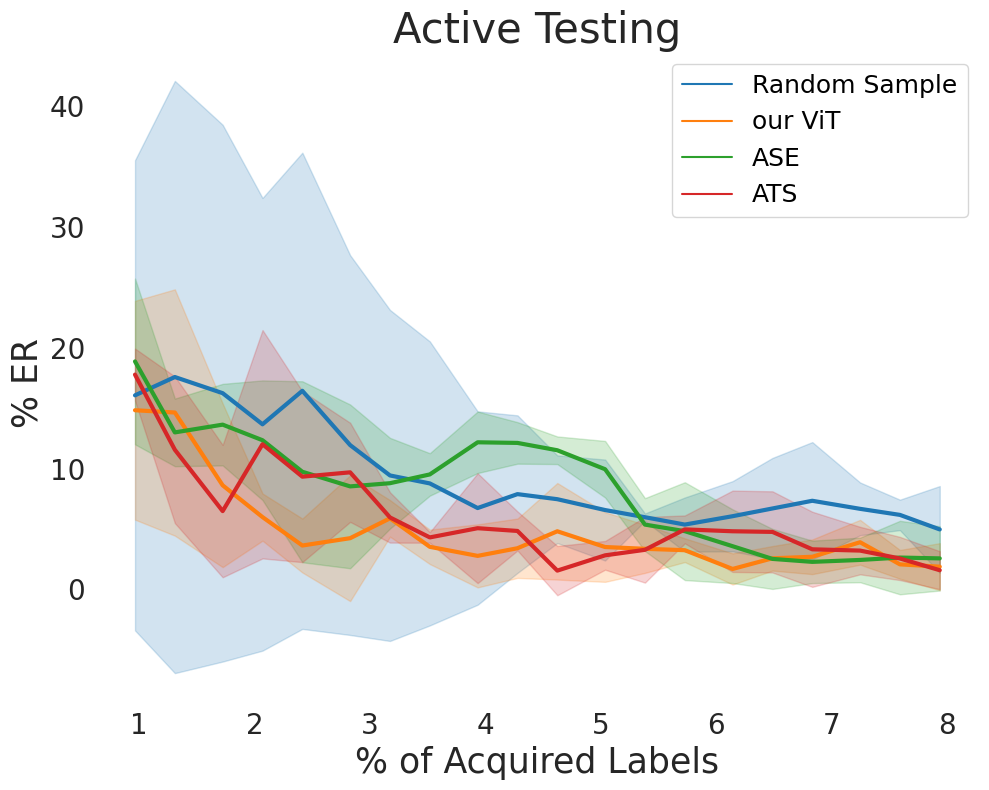

In [43]:
show_image_results("UNet_VOC", 10000)

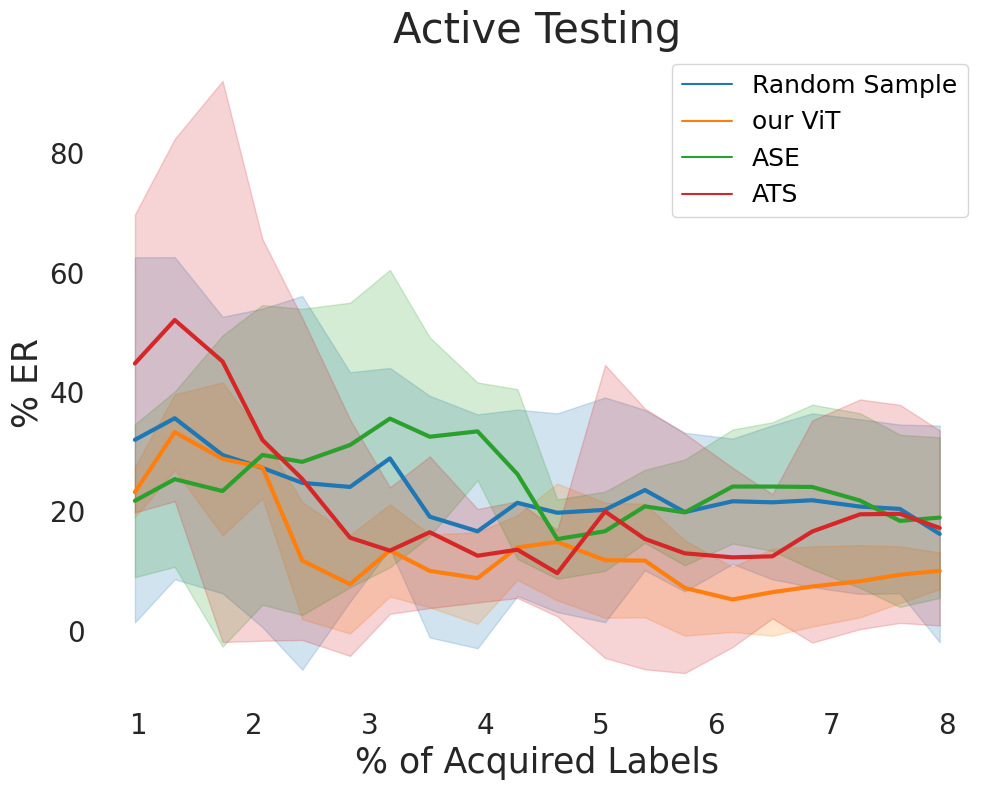

In [18]:
show_image_results("SEGNet_VOC", 20000)

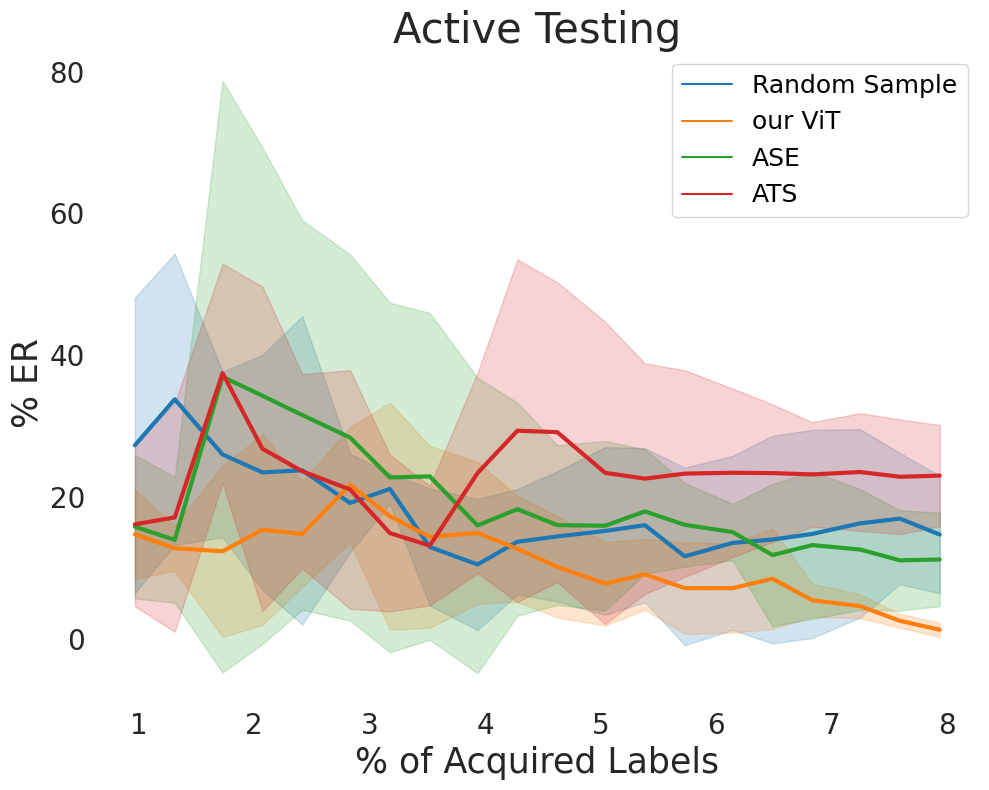

In [19]:
show_image_results("FCN_VOC", 5000)

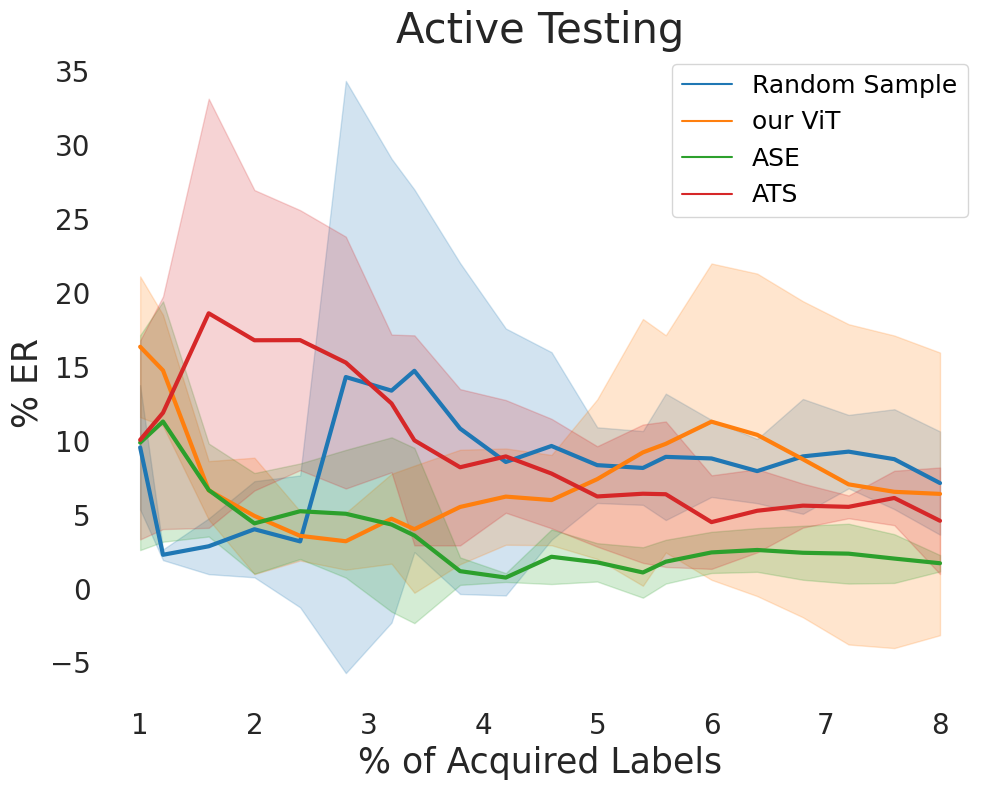

In [23]:
show_image_results("PSPNet_CITY", 20000)

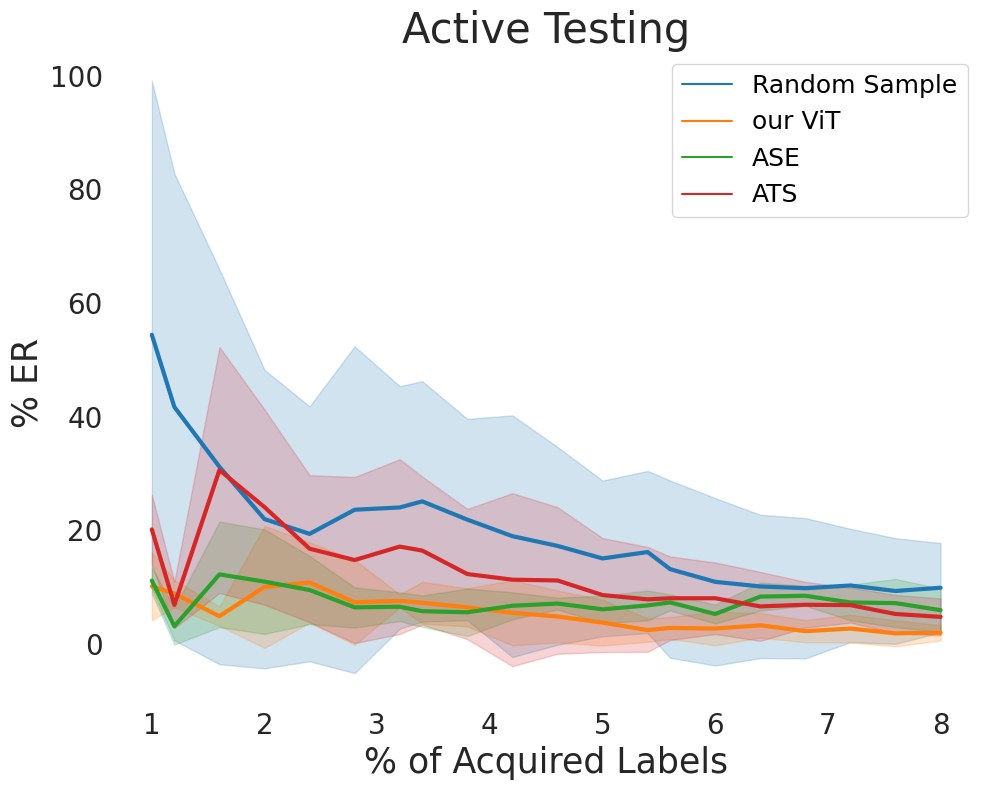

In [31]:
show_image_results("UNet_CITY", 20000)

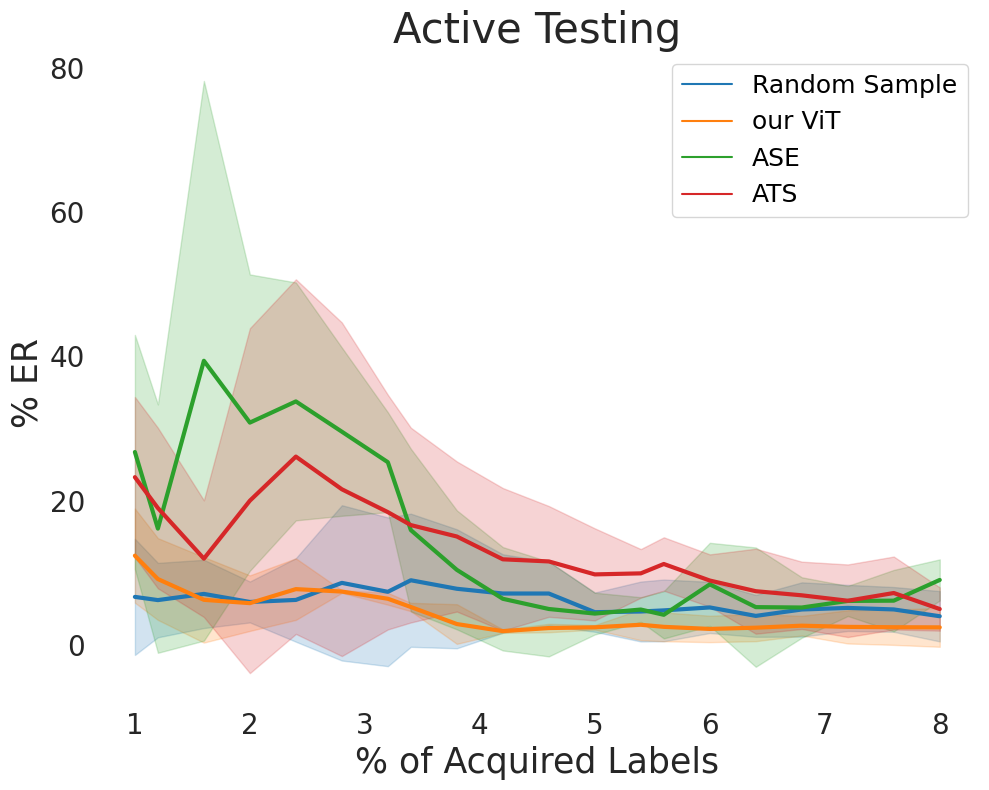

In [35]:
show_image_results("SEGNet_CITY", 5000)

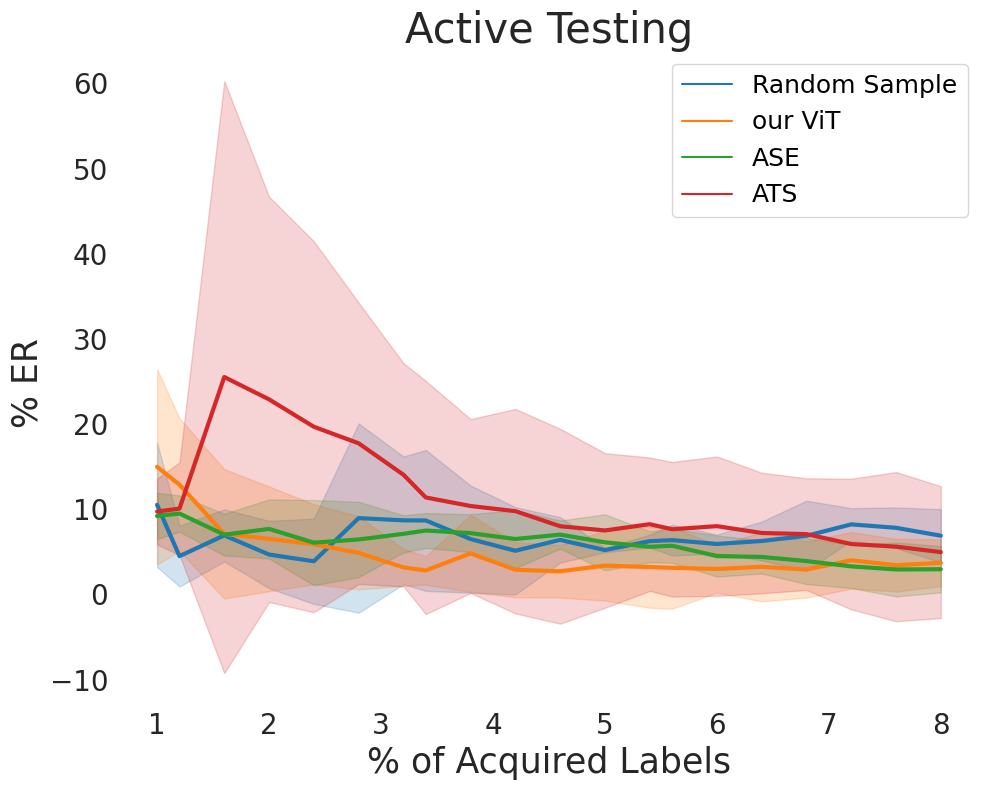

In [33]:
show_image_results("FCN_CITY", 10000)

## 16x16 Region based

In [50]:
## 16x16 based
method_dict = {"random sample": "Random Sample", "ViT region": "our ViT", "ASE region": "ASE", "AT region": "ATS", "ViT class 40": "our ViT"}
store_folder = "runs_3"
result_pd = {}
temp_list = []
def show_region_16_results(model_dataset, steps = 10000):
    show_results(model_dataset, steps, "region_16_16_true_losses.npy", "region_16_16_active_testing", "region")

def show_region_16_all_methods_mean_std(model_dataset, steps = 10000):
    show_all_methods_mean_std(model_dataset, steps, "region_16_16_true_losses.npy", "region_16_16_active_testing", "region")

def show_region_16_significance_value(model_dataset, steps = 10000):
    show_significance_value(model_dataset, steps, "region_16_16_true_losses.npy", "region_16_16_active_testing", "region")

In [51]:
show_region_16_all_methods_mean_std("PSPNet_COCO", 60000)
show_region_16_all_methods_mean_std("UNet_COCO", 15000)
show_region_16_all_methods_mean_std("SEGNet_COCO", 25000)
show_region_16_all_methods_mean_std("FCN_COCO", 10000)


show_region_16_all_methods_mean_std("PSPNet_ADE20K", 5000)
show_region_16_all_methods_mean_std("UNet_ADE20K", 15000)
show_region_16_all_methods_mean_std("SEGNet_ADE20K", 20000)
show_region_16_all_methods_mean_std("FCN_ADE20K", 35000)
df = pd.DataFrame(result_pd)
df.to_excel('excel/region_16_COCO.xlsx', index=False)

show_region_16_all_methods_mean_std("SEGNet_COCO_90", 20000)

./results/runs_3/PSPNet_COCO/region_16_16_active_testing/random_sample_3_runs.json: mean 5.38, std 3.73
./results/runs_3/PSPNet_COCO/region_16_16_active_testing/ViT_region_runs_60000.json: mean 2.67, std 2.21
./results/runs_3/PSPNet_COCO/region_16_16_active_testing/ASE_runs.json: mean 11.66, std 5.15
./results/runs_3/PSPNet_COCO/region_16_16_active_testing/AT_runs.json: mean 7.17, std 3.77
./results/runs_3/UNet_COCO/region_16_16_active_testing/random_sample_3_runs.json: mean 4.06, std 3.28
./results/runs_3/UNet_COCO/region_16_16_active_testing/ViT_region_runs_15000.json: mean 3.58, std 3.06
./results/runs_3/UNet_COCO/region_16_16_active_testing/ASE_runs.json: mean 3.62, std 3.32
./results/runs_3/UNet_COCO/region_16_16_active_testing/AT_runs.json: mean 4.09, std 2.98
./results/runs_3/SEGNet_COCO/region_16_16_active_testing/random_sample_3_runs.json: mean 3.06, std 2.44
./results/runs_3/SEGNet_COCO/region_16_16_active_testing/ViT_region_runs_25000.json: mean 3.09, std 2.96
./results/runs

In [49]:
dataset_model = "FCN_ADE20K"
# show_region_16_all_methods_mean_std(dataset_model, 5000)
# show_region_16_all_methods_mean_std(dataset_model, 10000)
# show_region_16_all_methods_mean_std(dataset_model, 15000)
# show_region_16_all_methods_mean_std(dataset_model, 20000)
show_region_16_all_methods_mean_std(dataset_model, 25000)
show_region_16_all_methods_mean_std(dataset_model, 30000)
show_region_16_all_methods_mean_std(dataset_model, 35000)
show_region_16_all_methods_mean_std(dataset_model, 40000)
show_region_16_all_methods_mean_std(dataset_model, 45000)
show_region_16_all_methods_mean_std(dataset_model, 50000)
show_region_16_all_methods_mean_std(dataset_model, 55000)
show_region_16_all_methods_mean_std(dataset_model, 60000)
show_region_16_all_methods_mean_std(dataset_model, 65000)
show_region_16_all_methods_mean_std(dataset_model, 70000)
show_region_16_all_methods_mean_std(dataset_model, 75000)
show_region_16_all_methods_mean_std(dataset_model, 80000)
show_region_16_all_methods_mean_std(dataset_model, 85000)
show_region_16_all_methods_mean_std(dataset_model, 90000)
# show_region_16_all_methods_mean_std(dataset_model, 95000)
show_region_16_all_methods_mean_std(dataset_model, 100000)

./results/runs_3/FCN_ADE20K/region_16_16_active_testing/random_sample_3_runs.json: mean 4.16, std 4.04
./results/runs_3/FCN_ADE20K/region_16_16_active_testing/ViT_region_runs_25000.json: mean 8.19, std 8.13
./results/runs_3/FCN_ADE20K/region_16_16_active_testing/ASE_runs.json: mean 11.20, std 10.12
./results/runs_3/FCN_ADE20K/region_16_16_active_testing/AT_runs.json: mean 8.07, std 4.99
./results/runs_3/FCN_ADE20K/region_16_16_active_testing/random_sample_3_runs.json: mean 4.16, std 4.04
./results/runs_3/FCN_ADE20K/region_16_16_active_testing/ViT_region_runs_30000.json: mean 5.87, std 4.79
./results/runs_3/FCN_ADE20K/region_16_16_active_testing/ASE_runs.json: mean 11.20, std 10.12
./results/runs_3/FCN_ADE20K/region_16_16_active_testing/AT_runs.json: mean 8.07, std 4.99
./results/runs_3/FCN_ADE20K/region_16_16_active_testing/random_sample_3_runs.json: mean 4.16, std 4.04
./results/runs_3/FCN_ADE20K/region_16_16_active_testing/ViT_region_runs_35000.json: mean 3.11, std 2.80
./results/run

In [23]:
show_region_16_significance_value("PSPNet_VOC", 10000)
print("====================================================================================================")
show_region_16_significance_value("UNet_VOC", 25000)
print("====================================================================================================")
show_region_16_significance_value("SEGNet_VOC", 15000)
print("====================================================================================================")
show_region_16_significance_value("FCN_VOC", 10000)
print("====================================================================================================")
show_region_16_significance_value("PSPNet_CITY", 10000)
print("====================================================================================================")
show_region_16_significance_value("UNet_CITY", 10000)
print("====================================================================================================")
show_region_16_significance_value("SEGNet_CITY", 10000)
print("====================================================================================================")
show_region_16_significance_value("FCN_CITY_40", 15000)
print("====================================================================================================")

PSPNet_VOC:
VIT:RS:  Ttest_indResult(statistic=-0.9668354014934207, pvalue=0.3883764714751944)
VIT:ASE:  Ttest_indResult(statistic=-0.11519815017345618, pvalue=0.9138394254274853)
VIT:AT:  Ttest_indResult(statistic=-0.27437127931305477, pvalue=0.7973863022252543)
UNet_VOC:
VIT:RS:  Ttest_indResult(statistic=-0.6563526778151846, pvalue=0.5474369044202928)
VIT:ASE:  Ttest_indResult(statistic=-0.3247635750943764, pvalue=0.7616352835889982)
VIT:AT:  Ttest_indResult(statistic=-0.3441755501885281, pvalue=0.7480466482242542)
SEGNet_VOC:
VIT:RS:  Ttest_indResult(statistic=-0.44844932806984616, pvalue=0.6770487235538836)
VIT:ASE:  Ttest_indResult(statistic=-1.2332309989497, pvalue=0.2850067952944559)
VIT:AT:  Ttest_indResult(statistic=0.8647968974501649, pvalue=0.43593086860236285)
FCN_VOC:
VIT:RS:  Ttest_indResult(statistic=-0.5427464964278724, pvalue=0.6161308099453264)
VIT:ASE:  Ttest_indResult(statistic=-0.8806241387619513, pvalue=0.4282531998826878)
VIT:AT:  Ttest_indResult(statistic=-1.19

In [22]:
show_region_16_all_methods_mean_std("PSPNet_VOC", 10000)
print("====================================================================================================")
show_region_16_all_methods_mean_std("UNet_VOC", 25000)
print("====================================================================================================")
show_region_16_all_methods_mean_std("SEGNet_VOC", 15000)
print("====================================================================================================")
show_region_16_all_methods_mean_std("FCN_VOC", 10000)
print("====================================================================================================")
show_region_16_all_methods_mean_std("PSPNet_CITY", 10000)
print("====================================================================================================")
show_region_16_all_methods_mean_std("UNet_CITY", 10000)
print("====================================================================================================")
show_region_16_all_methods_mean_std("SEGNet_CITY", 10000)
print("====================================================================================================")
show_region_16_all_methods_mean_std("FCN_CITY_40", 15000)
print("====================================================================================================")
df = pd.DataFrame(result_pd)
df.to_excel('excel/region_16_VOC.xlsx', index=False)

./results/runs_3/PSPNet_VOC/region_16_16_active_testing/random_sample_3_runs.json: mean 15.75, std 14.35
./results/runs_3/PSPNet_VOC/region_16_16_active_testing/ViT_region_runs_10000.json: mean 7.19, std 5.41
./results/runs_3/PSPNet_VOC/region_16_16_active_testing/ASE_runs.json: mean 7.73, std 6.11
./results/runs_3/PSPNet_VOC/region_16_16_active_testing/AT_runs.json: mean 8.73, std 8.10
./results/runs_3/UNet_VOC/region_16_16_active_testing/random_sample_3_runs.json: mean 4.41, std 3.46
./results/runs_3/UNet_VOC/region_16_16_active_testing/ViT_region_runs_25000.json: mean 2.73, std 2.76
./results/runs_3/UNet_VOC/region_16_16_active_testing/ASE_runs.json: mean 3.39, std 2.18
./results/runs_3/UNet_VOC/region_16_16_active_testing/AT_runs.json: mean 3.46, std 2.43
./results/runs_3/SEGNet_VOC/region_16_16_active_testing/random_sample_3_runs.json: mean 15.25, std 11.46
./results/runs_3/SEGNet_VOC/region_16_16_active_testing/ViT_region_runs_15000.json: mean 11.58, std 8.35
./results/runs_3/SEG

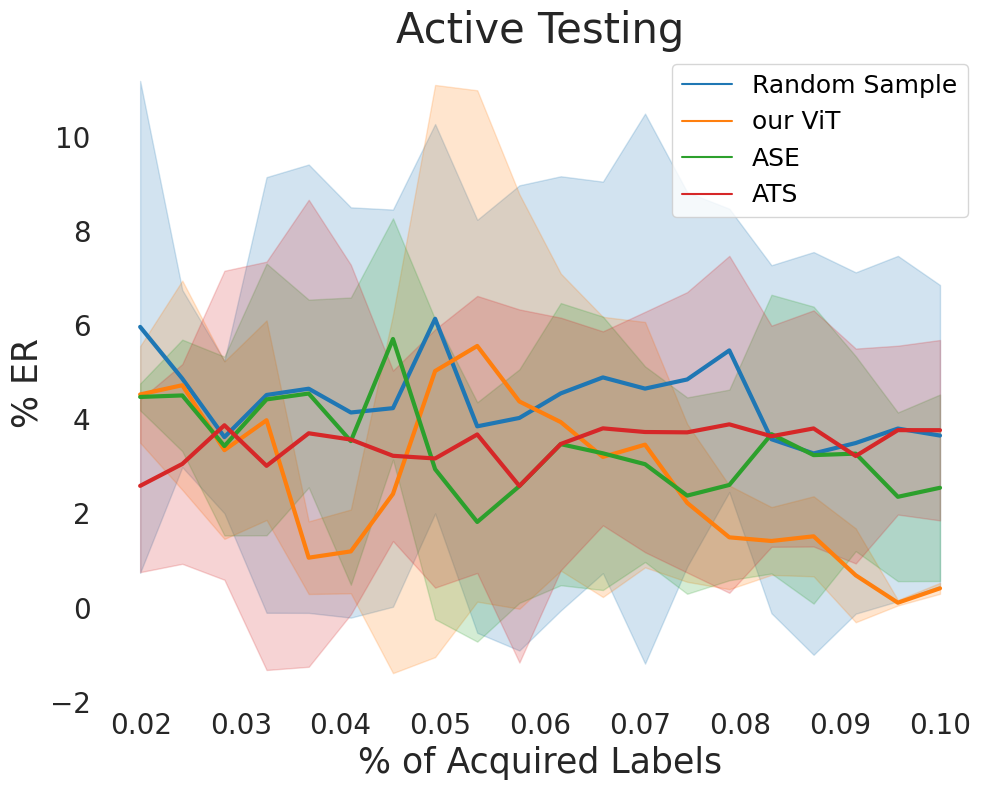

In [15]:
show_region_16_results("UNet_VOC", 25000)

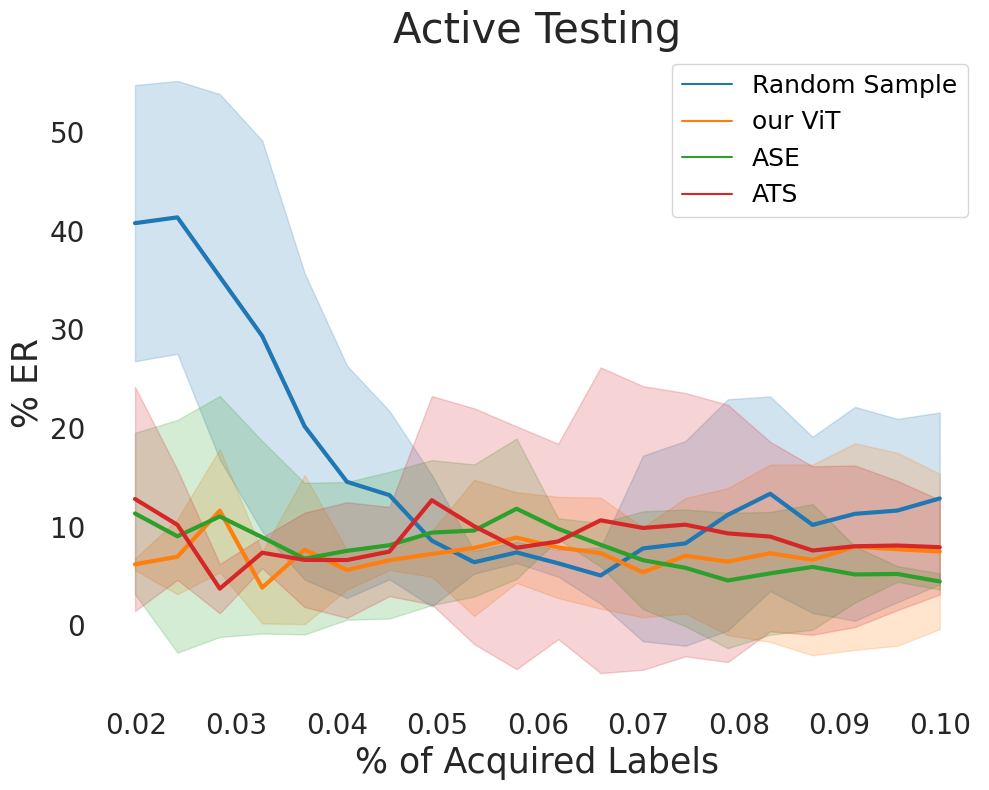

In [45]:
# show_region_16_results("PSPNet_VOC", 15000)
show_region_16_results("PSPNet_VOC", 10000)

In [16]:
# show_region_16_results("DeepLab_VOC", 20000)

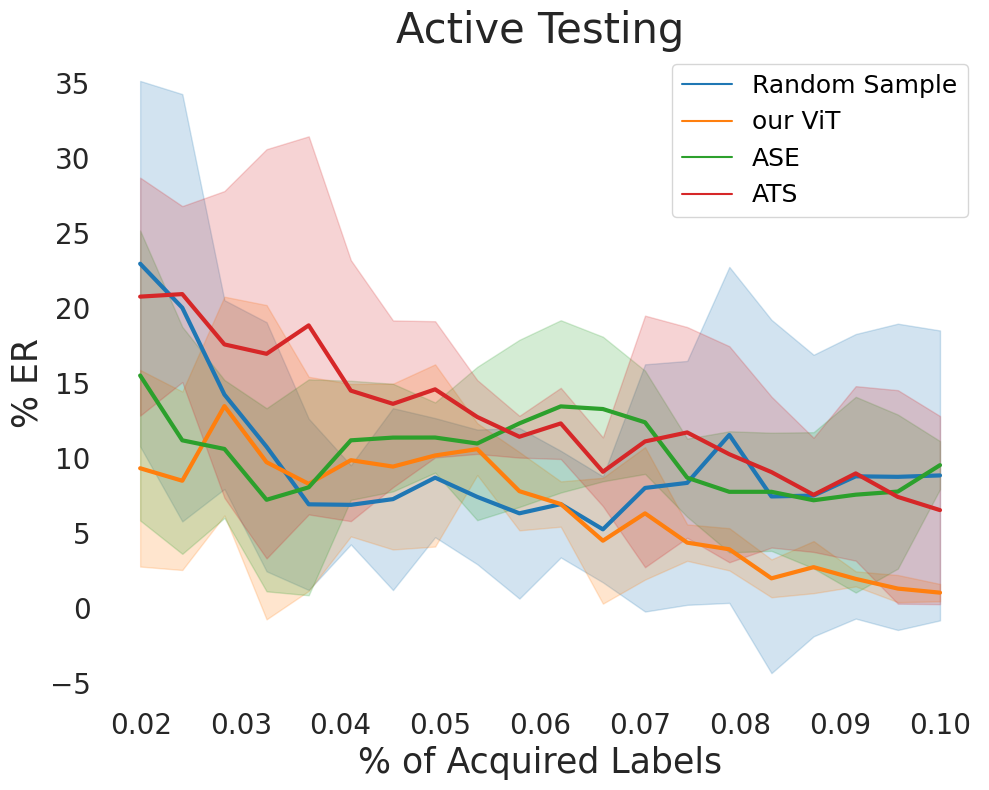

In [65]:
show_region_16_results("FCN_VOC", 10000)
# show_region_16_results("FCN_VOC", 20000)

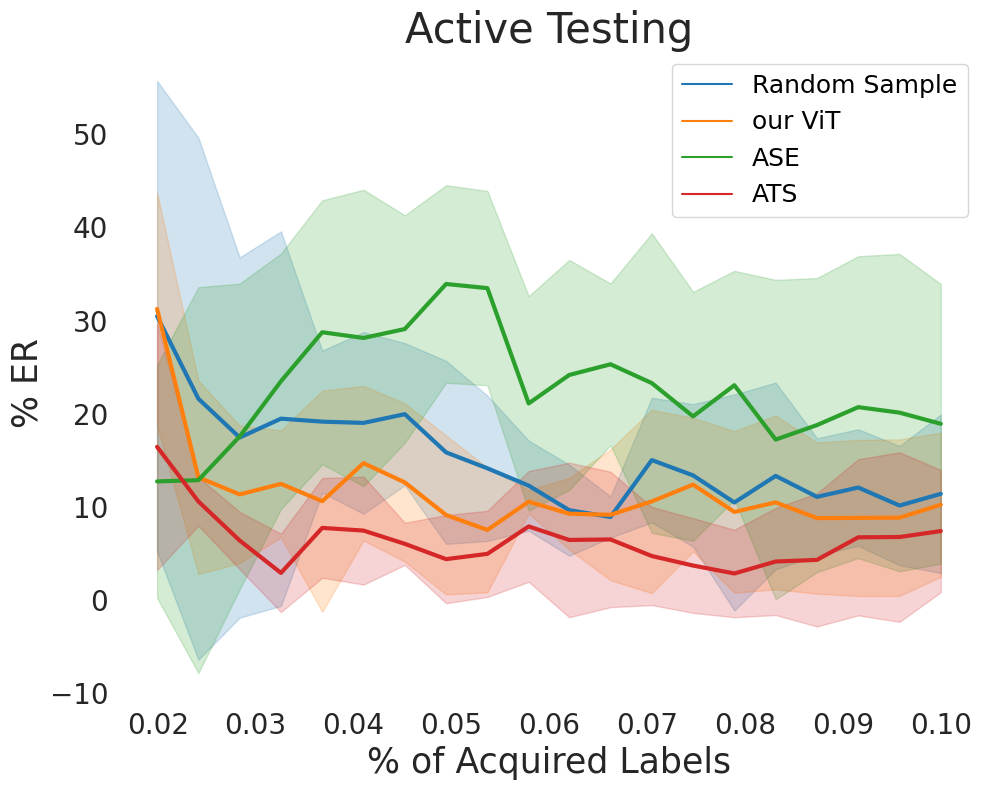

In [66]:
# show_region_16_results("SEGNet_VOC", 5000)
show_region_16_results("SEGNet_VOC", 15000)

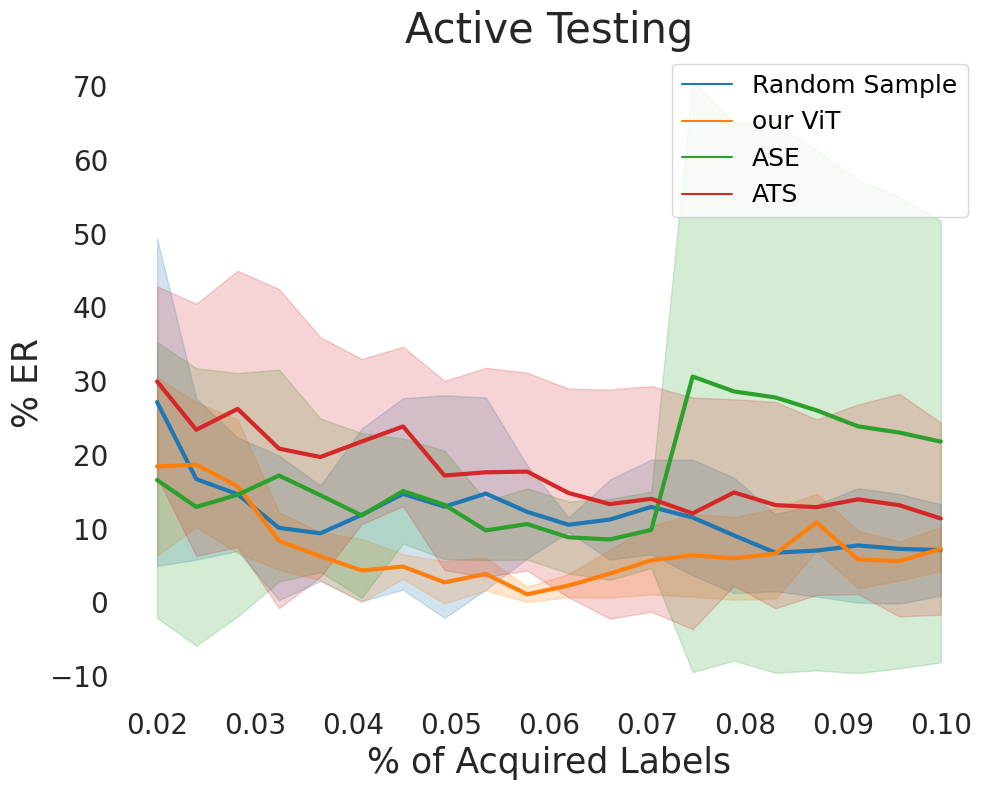

In [67]:
show_region_16_results("PSPNet_CITY", 10000)

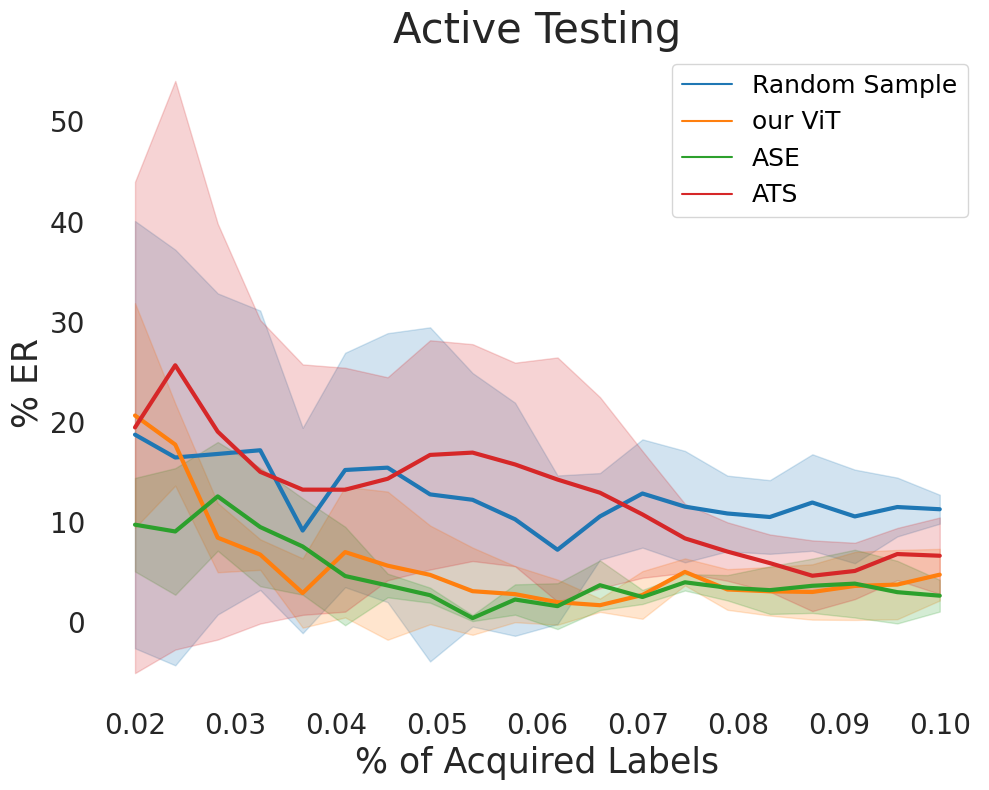

In [71]:
show_region_16_results("UNet_CITY", 10000)

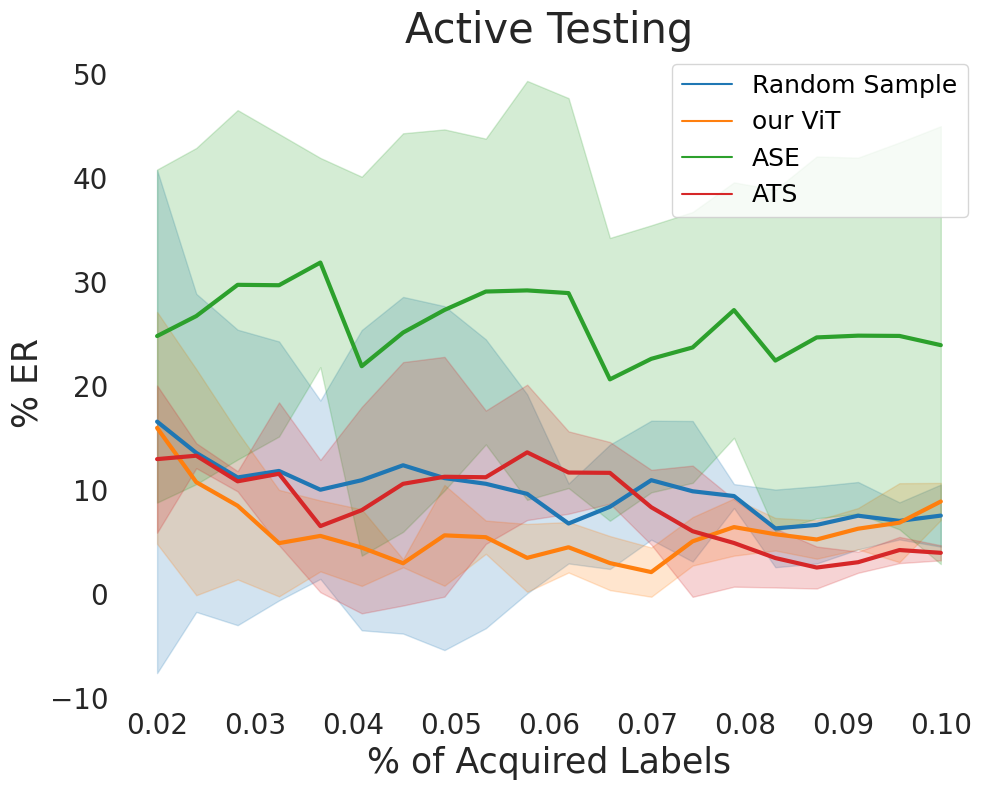

In [72]:
show_region_16_results("SEGNet_CITY", 10000)

In [73]:
# show_region_16_results("DeepLab_CITY", 15000)

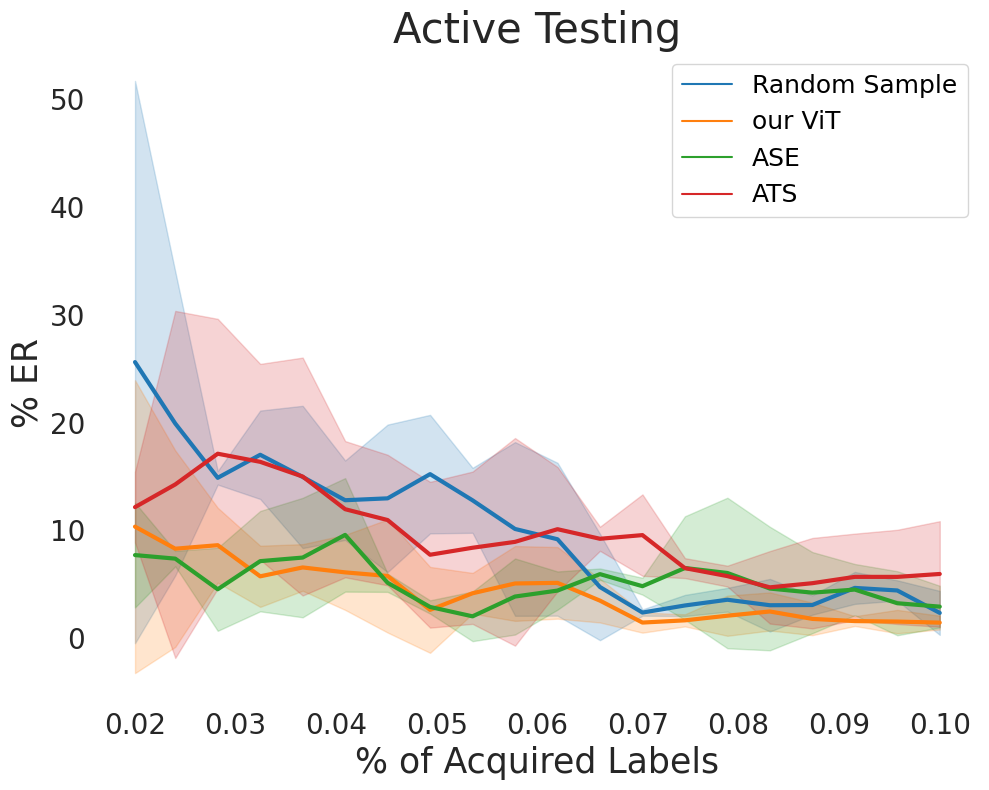

In [23]:
show_region_16_results("FCN_CITY_40", 15000)

## 32x32 Region based

In [11]:
result_pd = {}
temp_list = []
method_dict = {"random sample": "Random Sample", "ViT region 32": "our ViT", "ASE region 32": "ASE", "AT region 32": "ATS"}
store_folder = "runs_3"
def show_region_32_results(model_dataset, steps = 10000):
    show_results(model_dataset, steps, "region_32_32_true_losses.npy", "region_32_32_active_testing", "region")
    
def show_region_32_all_methods_mean_std(model_dataset, steps = 10000):
    show_all_methods_mean_std(model_dataset, steps, "region_32_32_true_losses.npy", "region_32_32_active_testing", "region")

def show_region_32_significance_value(model_dataset, steps = 10000):
    show_significance_value(model_dataset, steps, "region_32_32_true_losses.npy", "region_32_32_active_testing", "region")

In [15]:
show_region_32_all_methods_mean_std("PSPNet_COCO", 15000)
show_region_32_all_methods_mean_std("UNet_COCO", 5000)
show_region_32_all_methods_mean_std("SEGNet_COCO", 20000)
show_region_32_all_methods_mean_std("FCN_COCO", 10000)

show_region_32_all_methods_mean_std("PSPNet_ADE20K", 10000)
show_region_32_all_methods_mean_std("UNet_ADE20K", 10000)
show_region_32_all_methods_mean_std("SEGNet_ADE20K", 5000)
show_region_32_all_methods_mean_std("FCN_ADE20K_90", 20000)
df = pd.DataFrame(result_pd)
df.to_excel('excel/region_32_COCO.xlsx', index=False)

./results/runs_3/PSPNet_COCO/region_32_32_active_testing/random_sample_3_runs.json: mean 21.23, std 11.37
./results/runs_3/PSPNet_COCO/region_32_32_active_testing/ViT_region_runs_15000.json: mean 10.76, std 9.35
./results/runs_3/PSPNet_COCO/region_32_32_active_testing/ASE_runs.json: mean 17.83, std 12.42
./results/runs_3/PSPNet_COCO/region_32_32_active_testing/AT_runs.json: mean 11.19, std 8.92
./results/runs_3/UNet_COCO/region_32_32_active_testing/random_sample_3_runs.json: mean 9.76, std 9.14
./results/runs_3/UNet_COCO/region_32_32_active_testing/ViT_region_runs_5000.json: mean 4.84, std 3.90
./results/runs_3/UNet_COCO/region_32_32_active_testing/ASE_runs.json: mean 4.84, std 7.17
./results/runs_3/UNet_COCO/region_32_32_active_testing/AT_runs.json: mean 5.30, std 2.84
./results/runs_3/SEGNet_COCO/region_32_32_active_testing/random_sample_3_runs.json: mean 15.89, std 10.16
./results/runs_3/SEGNet_COCO/region_32_32_active_testing/ViT_region_runs_20000.json: mean 6.70, std 5.88
./result

In [14]:
dataset_model = "UNet_COCO"
show_region_32_all_methods_mean_std(dataset_model, 5000)
show_region_32_all_methods_mean_std(dataset_model, 10000)
show_region_32_all_methods_mean_std(dataset_model, 15000)
show_region_32_all_methods_mean_std(dataset_model, 20000)

./results/runs_3/UNet_COCO/region_32_32_active_testing/random_sample_3_runs.json: mean 9.76, std 9.14
./results/runs_3/UNet_COCO/region_32_32_active_testing/ViT_region_runs_5000.json: mean 4.84, std 3.90
./results/runs_3/UNet_COCO/region_32_32_active_testing/ASE_runs.json: mean 4.84, std 7.17
./results/runs_3/UNet_COCO/region_32_32_active_testing/AT_runs.json: mean 5.30, std 2.84
./results/runs_3/UNet_COCO/region_32_32_active_testing/random_sample_3_runs.json: mean 9.76, std 9.14
./results/runs_3/UNet_COCO/region_32_32_active_testing/ViT_region_runs_10000.json: mean 5.07, std 4.01
./results/runs_3/UNet_COCO/region_32_32_active_testing/ASE_runs.json: mean 4.84, std 7.17
./results/runs_3/UNet_COCO/region_32_32_active_testing/AT_runs.json: mean 5.30, std 2.84
./results/runs_3/UNet_COCO/region_32_32_active_testing/random_sample_3_runs.json: mean 9.76, std 9.14
./results/runs_3/UNet_COCO/region_32_32_active_testing/ViT_region_runs_15000.json: mean 5.40, std 5.72
./results/runs_3/UNet_COCO/r

In [28]:
show_region_32_significance_value("PSPNet_VOC", 5000)
print("====================================================================================================")
show_region_32_significance_value("UNet_VOC", 10000)
print("====================================================================================================")
show_region_32_significance_value("SEGNet_VOC", 10000)
print("====================================================================================================")
show_region_32_significance_value("FCN_VOC", 10000)
print("====================================================================================================")
show_region_32_significance_value("PSPNet_CITY", 15000)
print("====================================================================================================")
show_region_32_significance_value("UNet_CITY", 20000)
print("====================================================================================================")
show_region_32_significance_value("SEGNet_CITY", 15000)
print("====================================================================================================")
show_region_32_significance_value("FCN_CITY", 20000)
print("====================================================================================================")

PSPNet_VOC:
VIT:RS:  Ttest_indResult(statistic=-0.891165985780423, pvalue=0.42320116307583827)
VIT:ASE:  Ttest_indResult(statistic=-0.7739792302802618, pvalue=0.48214402052890903)
VIT:AT:  Ttest_indResult(statistic=-0.9515309146950186, pvalue=0.39521734328066327)
UNet_VOC:
VIT:RS:  Ttest_indResult(statistic=-0.536791949949548, pvalue=0.6198768678910336)
VIT:ASE:  Ttest_indResult(statistic=0.2877836878057656, pvalue=0.7878071055610731)
VIT:AT:  Ttest_indResult(statistic=-0.06538853627368135, pvalue=0.9510022330702712)
SEGNet_VOC:
VIT:RS:  Ttest_indResult(statistic=-0.7221274170037452, pvalue=0.5101760581550986)
VIT:ASE:  Ttest_indResult(statistic=-1.8961004544561053, pvalue=0.13082610030789943)
VIT:AT:  Ttest_indResult(statistic=-0.8297664611699864, pvalue=0.45332047116857677)
FCN_VOC:
VIT:RS:  Ttest_indResult(statistic=0.03065276859709224, pvalue=0.9770149226148644)
VIT:ASE:  Ttest_indResult(statistic=-0.5774408568640834, pvalue=0.5945865467277609)
VIT:AT:  Ttest_indResult(statistic=0.

In [26]:
show_region_32_all_methods_mean_std("PSPNet_VOC", 5000)
print("====================================================================================================")
show_region_32_all_methods_mean_std("UNet_VOC", 10000)
print("====================================================================================================")
show_region_32_all_methods_mean_std("SEGNet_VOC", 10000)
print("====================================================================================================")
show_region_32_all_methods_mean_std("FCN_VOC", 10000)
print("====================================================================================================")
show_region_32_all_methods_mean_std("PSPNet_CITY", 15000)
print("====================================================================================================")
show_region_32_all_methods_mean_std("UNet_CITY", 20000)
print("====================================================================================================")
show_region_32_all_methods_mean_std("SEGNet_CITY", 15000)
print("====================================================================================================")
show_region_32_all_methods_mean_std("FCN_CITY", 20000)
print("====================================================================================================")
df = pd.DataFrame(result_pd)
df.to_excel('excel/region_32_VOC.xlsx', index=False)

./results/runs_3/PSPNet_VOC/region_32_32_active_testing/random_sample_3_runs.json: mean 25.45, std 15.26
./results/runs_3/PSPNet_VOC/region_32_32_active_testing/ViT_region_runs_5000.json: mean 16.17, std 9.59
./results/runs_3/PSPNet_VOC/region_32_32_active_testing/ASE_runs.json: mean 31.78, std 33.59
./results/runs_3/PSPNet_VOC/region_32_32_active_testing/AT_runs.json: mean 25.89, std 14.86
./results/runs_3/UNet_VOC/region_32_32_active_testing/random_sample_3_runs.json: mean 9.38, std 7.52
./results/runs_3/UNet_VOC/region_32_32_active_testing/ViT_region_runs_10000.json: mean 6.53, std 5.26
./results/runs_3/UNet_VOC/region_32_32_active_testing/ASE_runs.json: mean 5.44, std 3.97
./results/runs_3/UNet_VOC/region_32_32_active_testing/AT_runs.json: mean 6.82, std 5.38
./results/runs_3/SEGNet_VOC/region_32_32_active_testing/random_sample_3_runs.json: mean 29.80, std 33.67
./results/runs_3/SEGNet_VOC/region_32_32_active_testing/ViT_region_runs_10000.json: mean 15.18, std 9.86
./results/runs_3

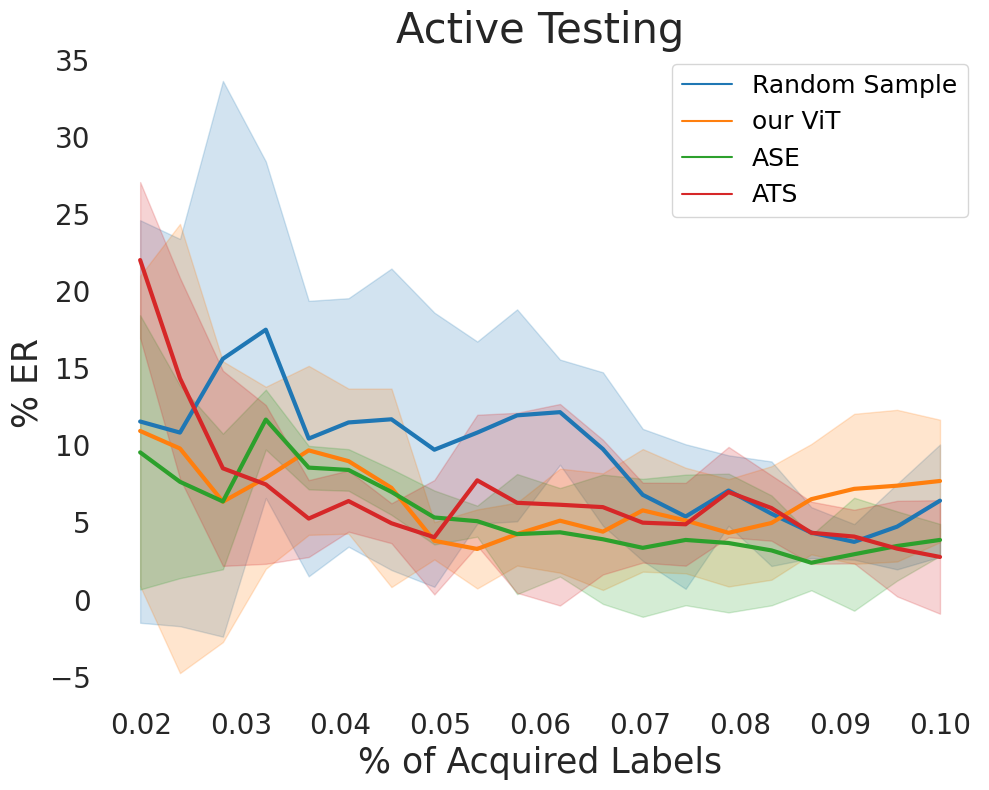

In [9]:
show_region_32_results("UNet_VOC", 10000)

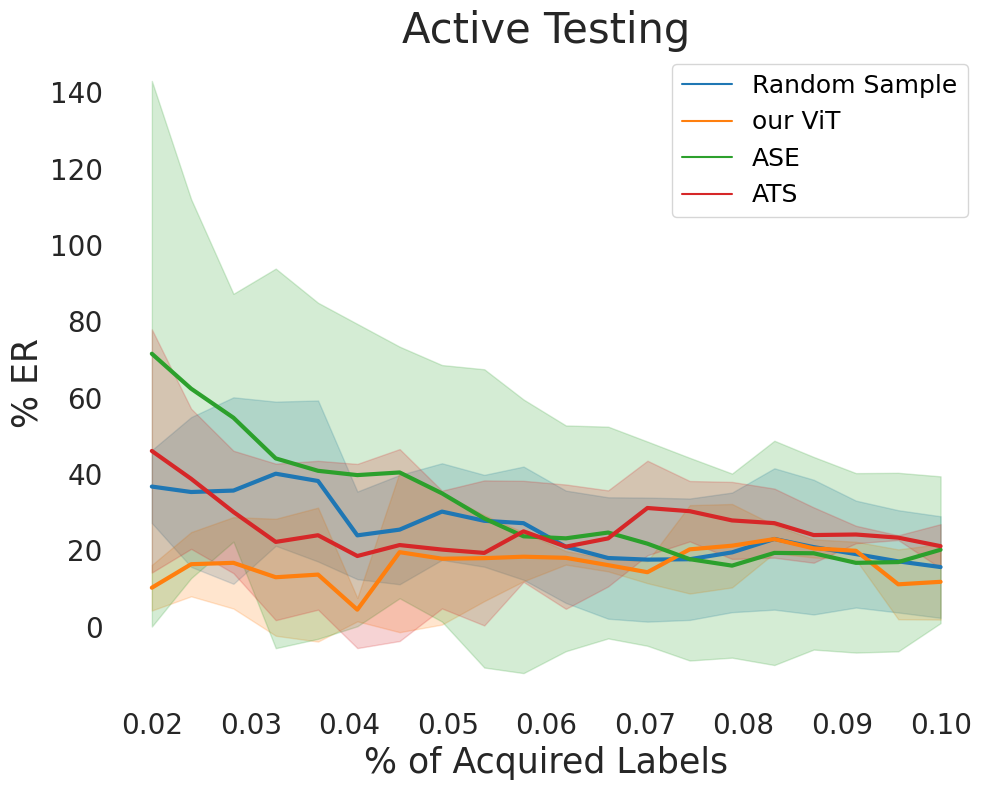

In [10]:
# show_region_32_results("PSPNet_VOC", 10000)
show_region_32_results("PSPNet_VOC", 5000)

In [38]:
# show_region_32_results("DeepLab_VOC", 10000)

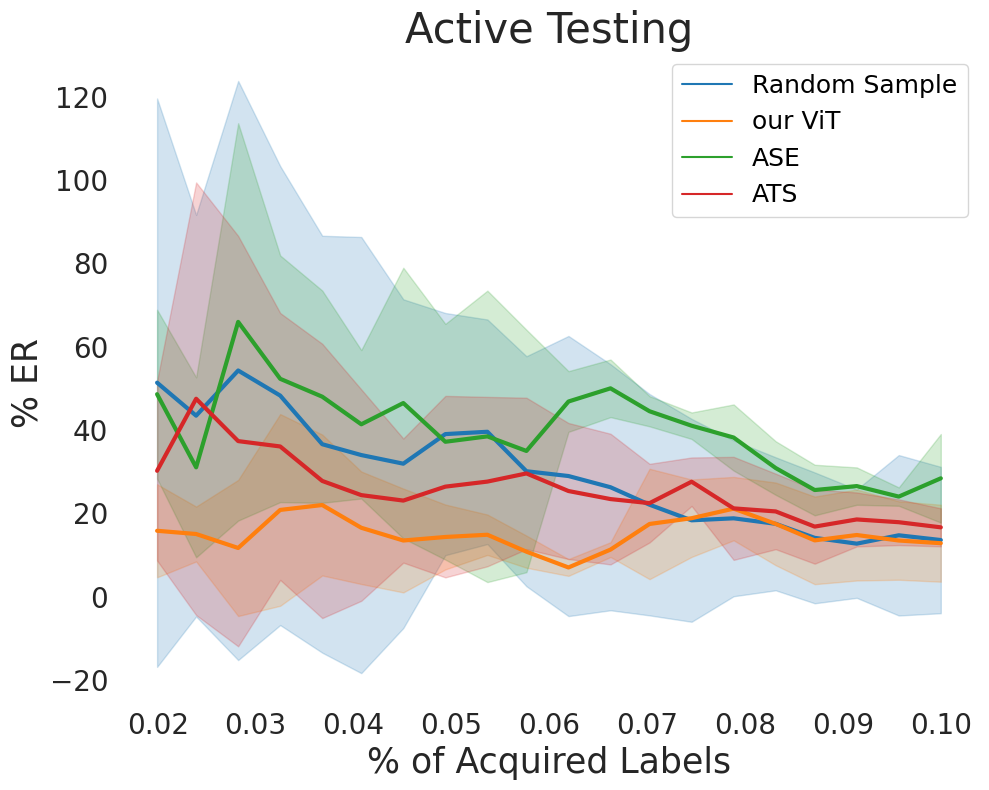

In [11]:
show_region_32_results("SEGNet_VOC", 10000)

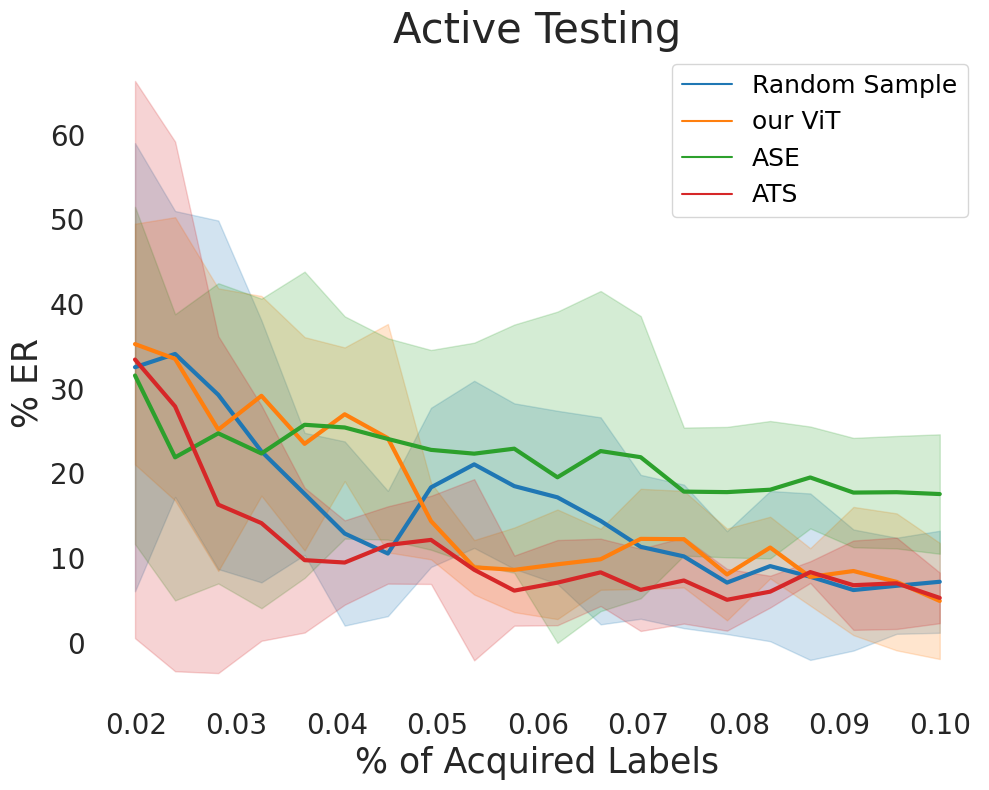

In [12]:
show_region_32_results("FCN_VOC", 10000)

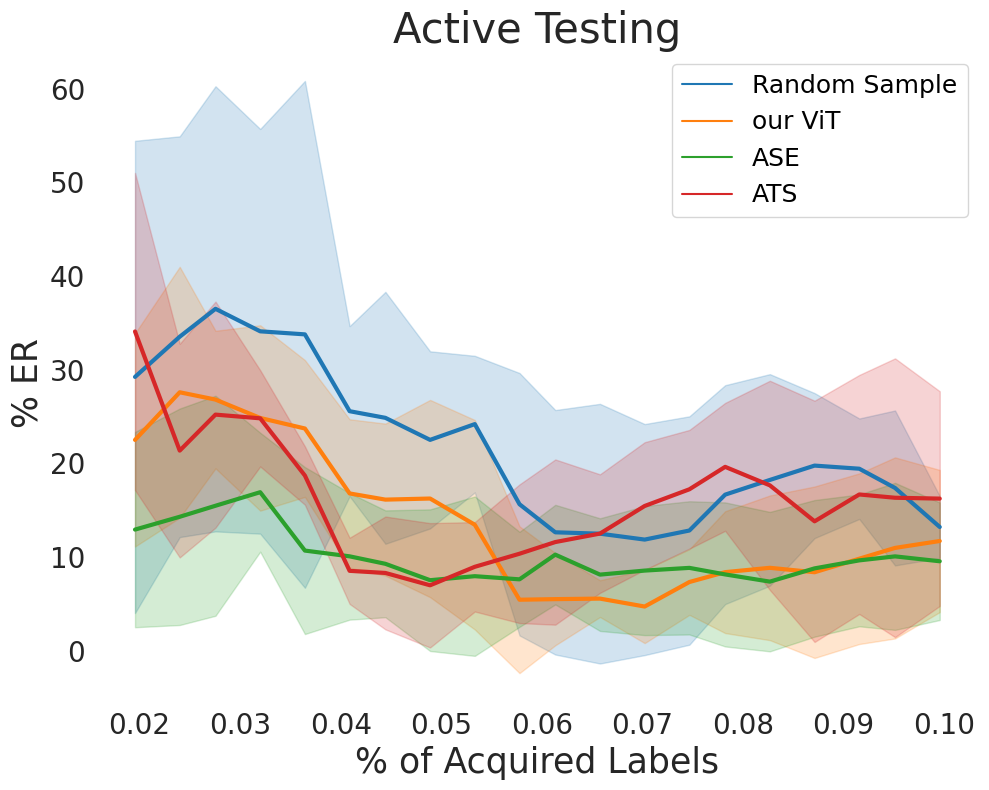

In [13]:
show_region_32_results("PSPNet_CITY", 15000)

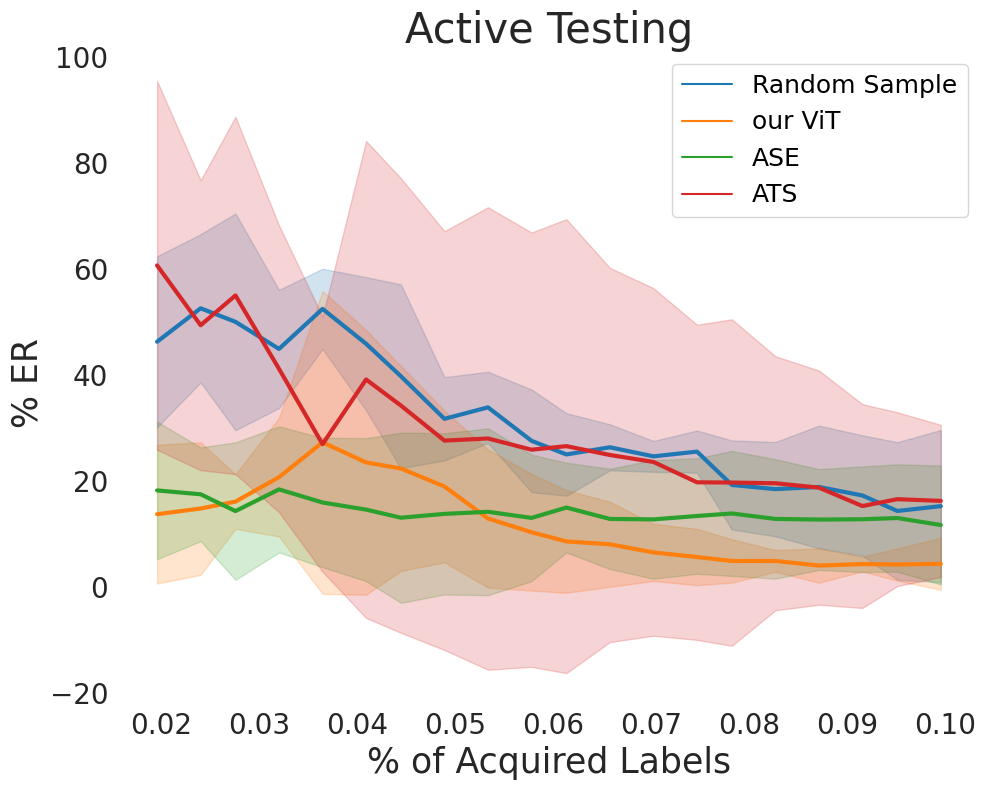

In [14]:
show_region_32_results("UNet_CITY", 20000)

In [43]:
# show_region_32_results("DeepLab_CITY", 20000)

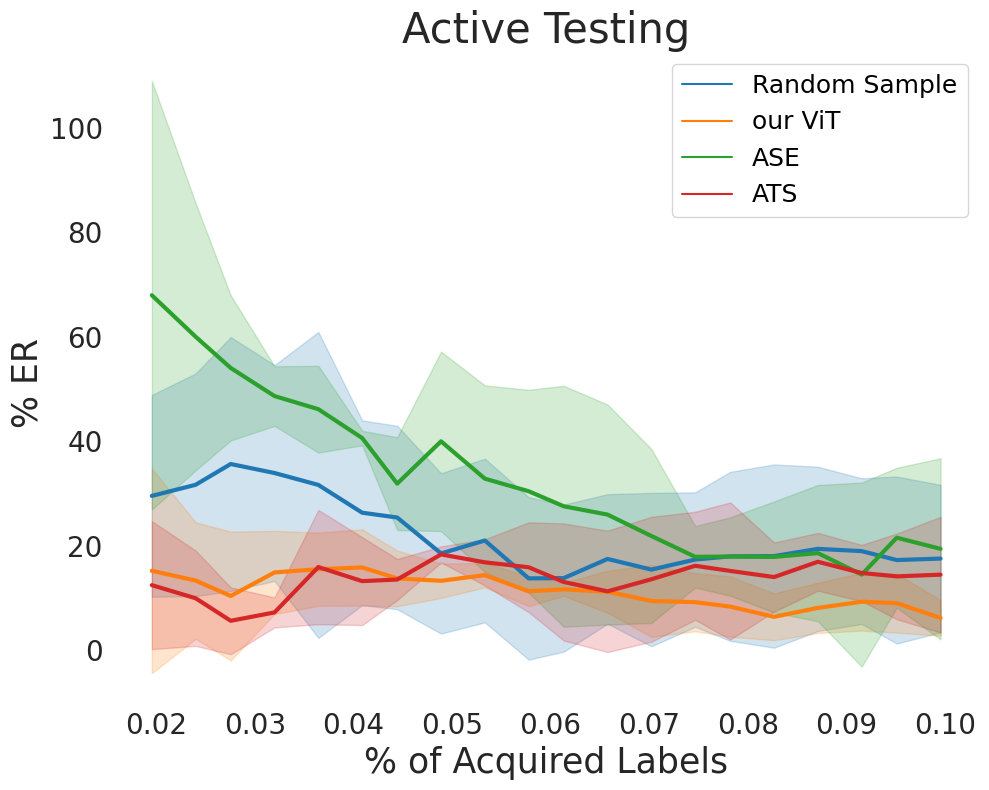

In [15]:
show_region_32_results("SEGNet_CITY", 15000)

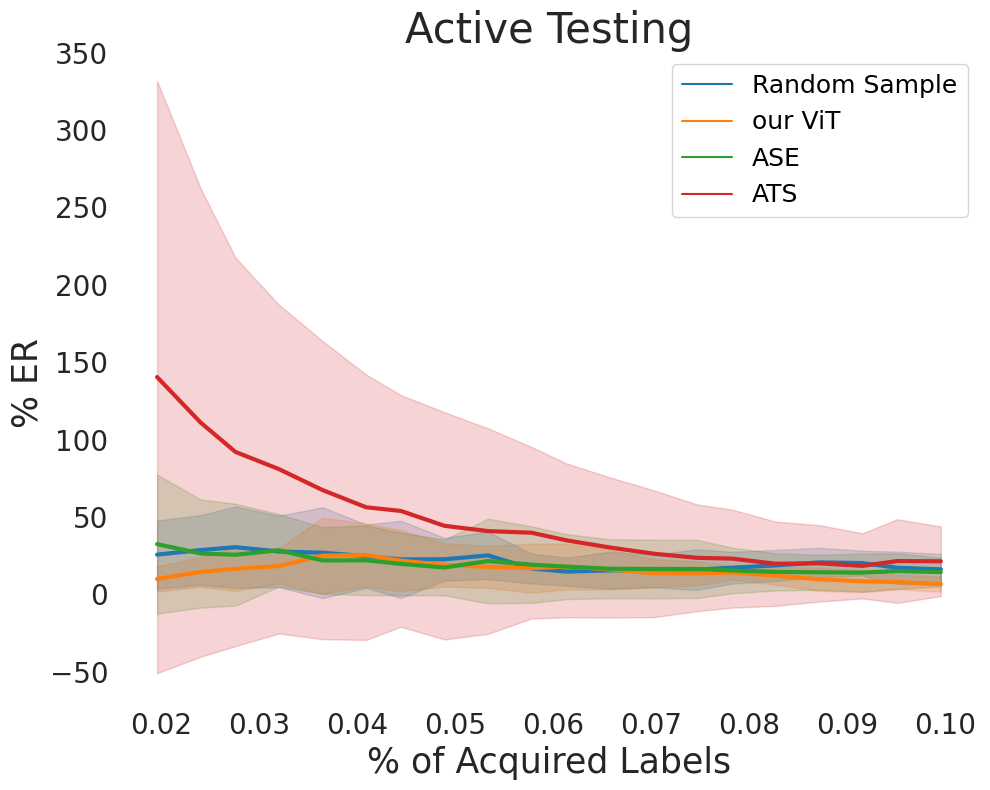

In [16]:
show_region_32_results("FCN_CITY", 20000)

## 8x8 Region based

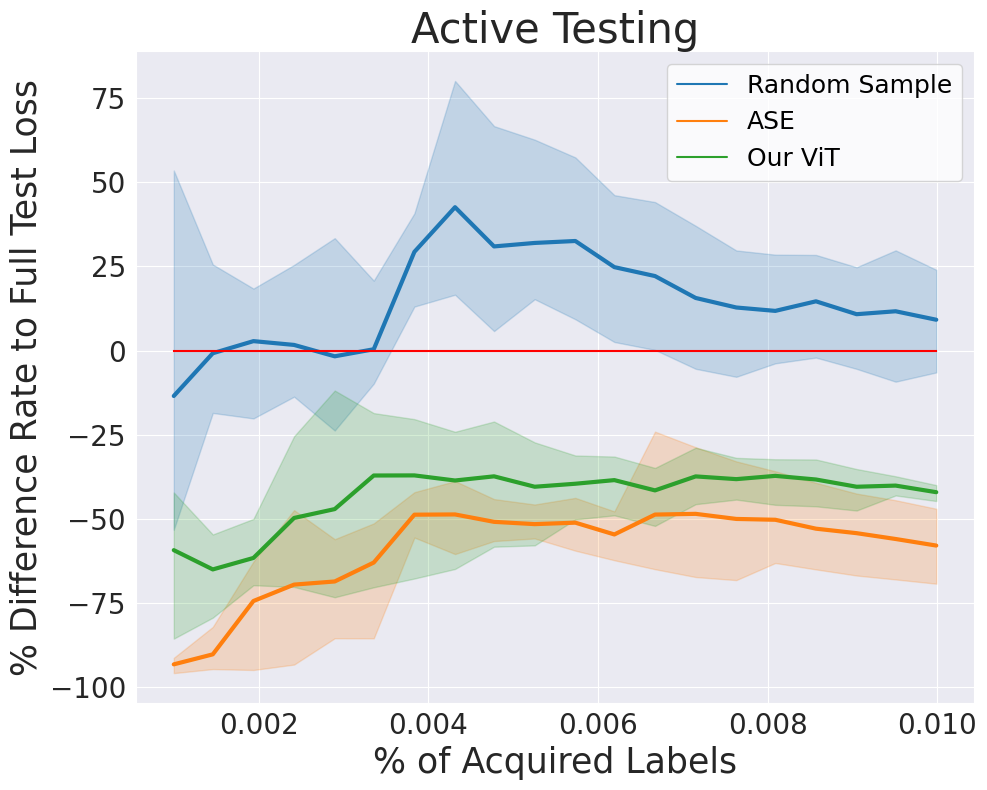

In [6]:
# 8 x 8
model_dataset = "PSPNet_VOC"
base_path = f"./pro_data/{model_dataset}/val/"
sample_size_threshold = np_read(base_path + "region_8_8_true_losses.npy").shape[0]
method_dict = {"random sample": "Random Sample", "ViT": "Our ViT", "temp":"temp", "MLP": "MLP", "ordinal": "ordinal", "ASE": "ASE"}
result_json_path = f"./results/{model_dataset}/region_8_8_active_testing/"
true_loss_estimation_path = result_json_path + "None.json"
test_whole_data = read_baseline_data(true_loss_estimation_path)
results = add_entries(result_json_path + "random_sample_3_runs.json")
results =  results.append(add_entries(result_json_path + "ase_runs.json"),ignore_index=True)
results =  results.append(add_entries(result_json_path + "ViT_output_train_ordinal_runs.json"),ignore_index=True)
plot_all_diff_precentage_figure(results, test_whole_data, sample_size_threshold, "loss", x_label_name = "% of Acquired Labels")

## Ablation Study

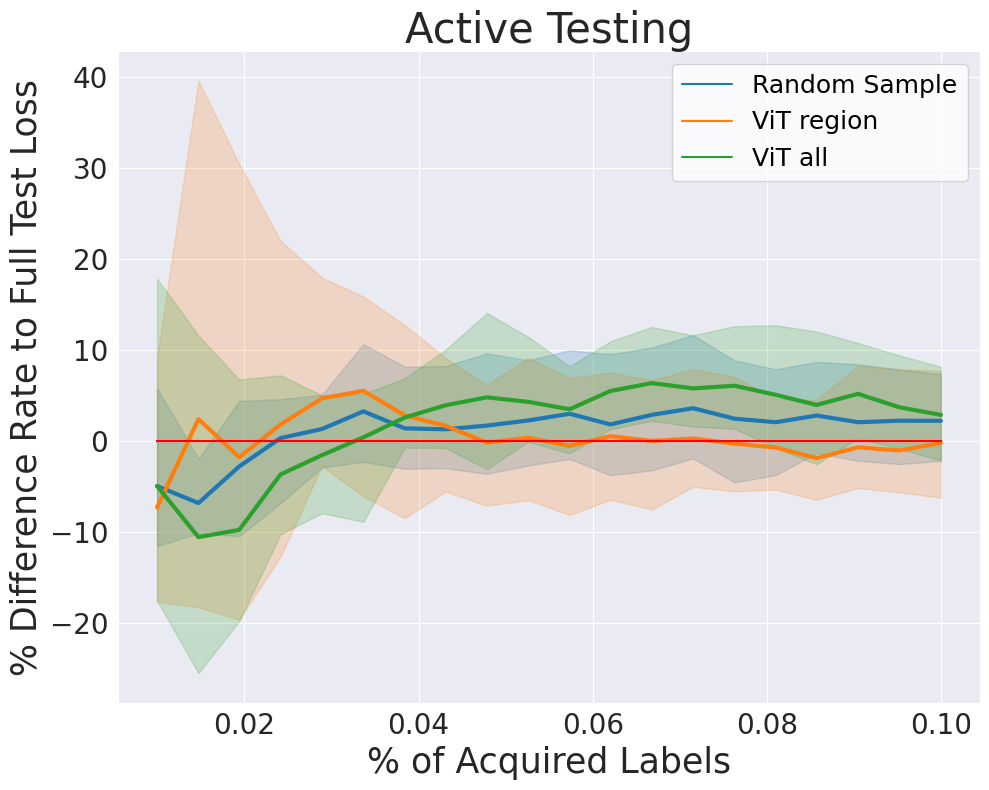

In [24]:
# 16x16,whether to train image and region 16x16 together
method_dict = {"random sample": "Random Sample", "ViT all": "ViT all", "ViT region": "ViT region", "ASE": "ASE"}
model_dataset = "UNet_VOC"
base_path = f"./pro_data/{model_dataset}/val/"
sample_size_threshold = np_read(base_path + "region_16_16_true_losses.npy").shape[0]
result_json_path = f"./results/{model_dataset}/region_16_16_active_testing/"
true_loss_estimation_path = result_json_path + "None.json"
test_whole_data = read_baseline_data(true_loss_estimation_path)
results = add_entries(result_json_path + "random_sample_3_runs.json")
results =  results.append(add_entries(result_json_path + "ViT_range_region_runs_10000.json"),ignore_index=True)
results =  results.append(add_entries(result_json_path + "ViT_range_all_runs_10000.json"),ignore_index=True)
# results =  results.append(add_entries(result_json_path + "ase_runs.json"),ignore_index=True)
plot_all_diff_precentage_figure(results, test_whole_data, sample_size_threshold, "loss", x_label_name = "% of Acquired Labels")

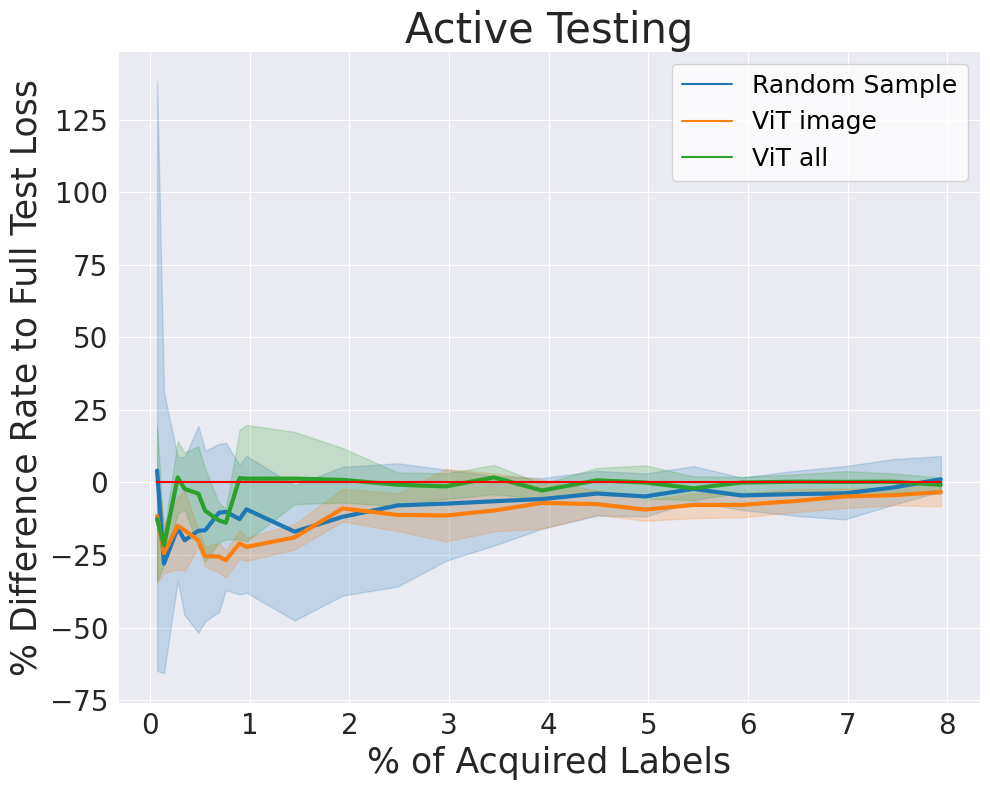

In [21]:
# image, whether to train image and region 16x16 together
method_dict = {"random sample": "Random Sample", "ViT all": "ViT all", "ViT image": "ViT image"}
model_dataset = "UNet_VOC"
base_path = f"./pro_data/{model_dataset}/val/"
sample_size_threshold = np_read(base_path + "image_true_losses.npy").shape[0]
result_json_path = f"./results/{model_dataset}/image_based_active_testing/"
true_loss_estimation_path = result_json_path + "None.json"
test_whole_data = read_baseline_data(true_loss_estimation_path)
results = add_entries(result_json_path + "random_sample_3_runs.json")
results =  results.append(add_entries(result_json_path + "ViT_range_image_runs_10000.json"),ignore_index=True)
results =  results.append(add_entries(result_json_path + "ViT_range_all_runs_10000.json"),ignore_index=True)
plot_all_diff_precentage_figure(results, test_whole_data, sample_size_threshold, "loss", x_label_name = "% of Acquired Labels")

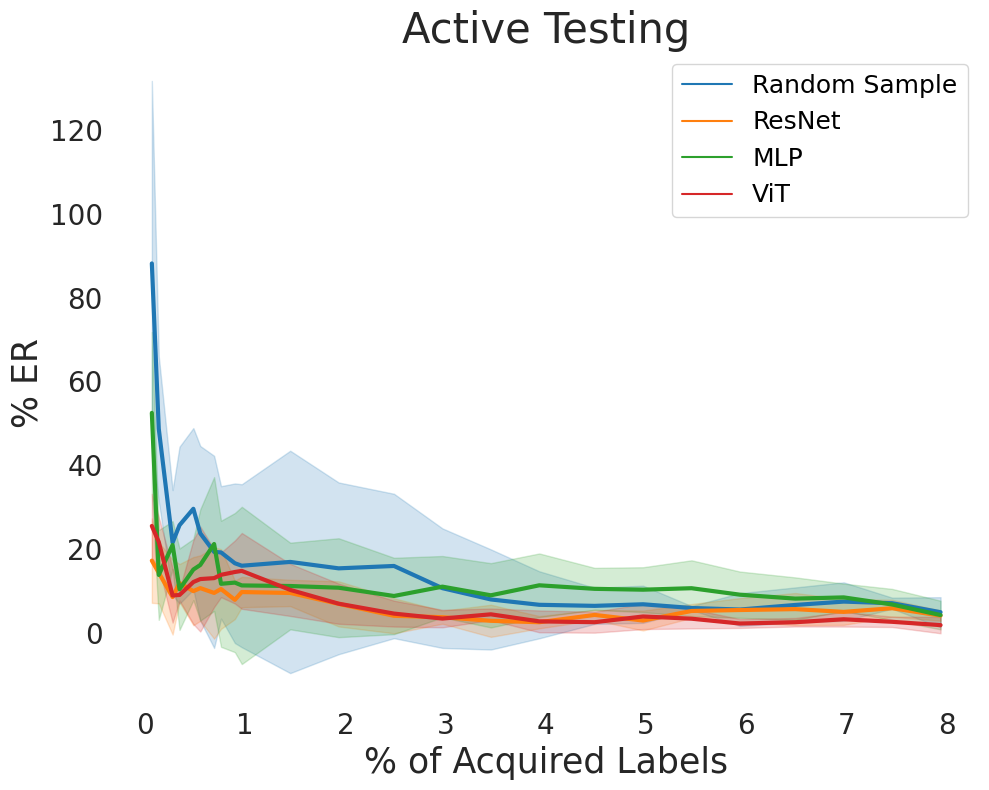

In [19]:
# image, ResNet vs ViT vs MLP
method_dict = {"random sample": "Random Sample", "ViT all": "ViT", "MLP": "MLP", "ResNet": "ResNet", "ViT reg": "ViT reg"}
model_dataset = "UNet_VOC"
base_path = f"./pro_data/{model_dataset}/val/"
sample_size_threshold = np_read(base_path + "image_true_losses.npy").shape[0]
result_json_path = f"./results/previous/{model_dataset}/image_based_active_testing/"
true_loss_estimation_path = result_json_path + "None.json"
test_whole_data = read_baseline_data(true_loss_estimation_path)
results = add_entries(result_json_path + "random_sample_3_runs.json")
results =  results.append(add_entries(result_json_path + "ResNet_UNet_VOC_image_runs_20000.json"),ignore_index=True)
results =  results.append(add_entries(result_json_path + "MLP_UNet_VOC_image_runs_20000.json"),ignore_index=True)
results =  results.append(add_entries(result_json_path + "ViT_range_all_runs_10000.json"),ignore_index=True)
plot_all_diff_precentage_figure(results, test_whole_data, sample_size_threshold, "loss", x_label_name = "% of Acquired Labels")

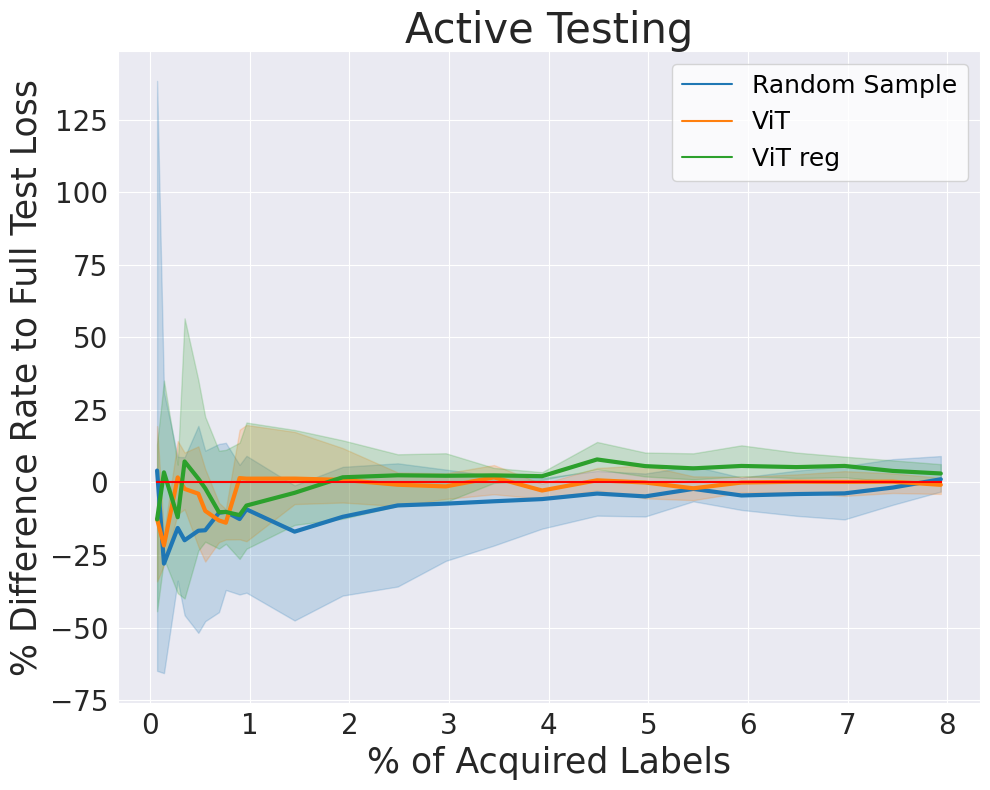

In [26]:
# image, ViT ordinal VS regression
method_dict = {"random sample": "Random Sample", "ViT all": "ViT", "MLP": "MLP", "ResNet": "ResNet", "ViT reg": "ViT reg"}
model_dataset = "UNet_VOC"
base_path = f"./pro_data/{model_dataset}/val/"
sample_size_threshold = np_read(base_path + "image_true_losses.npy").shape[0]
result_json_path = f"./results/{model_dataset}/image_based_active_testing/"
true_loss_estimation_path = result_json_path + "None.json"
test_whole_data = read_baseline_data(true_loss_estimation_path)
results = add_entries(result_json_path + "random_sample_3_runs.json")
results =  results.append(add_entries(result_json_path + "ViT_range_all_runs_10000.json"),ignore_index=True)
results =  results.append(add_entries(result_json_path + "ViT_UNet_VOC_regress_image_runs_20000.json"),ignore_index=True)
plot_all_diff_precentage_figure(results, test_whole_data, sample_size_threshold, "loss", x_label_name = "% of Acquired Labels")

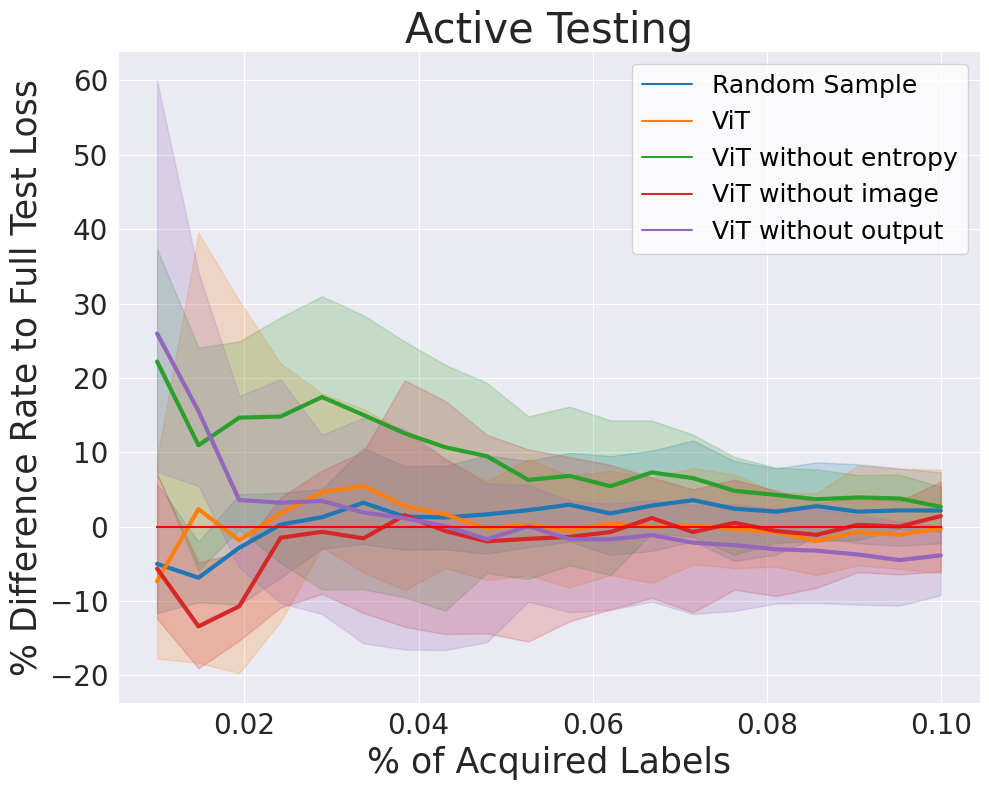

In [15]:
# 16x16, model input
method_dict = {"random sample": "Random Sample", "ViT without entropy": "ViT without entropy", "ViT without image": "ViT without image", "ViT without output": "ViT without output", "ViT region": "ViT"}
model_dataset = "UNet_VOC"
base_path = f"./pro_data/{model_dataset}/val/"
sample_size_threshold = np_read(base_path + "region_16_16_true_losses.npy").shape[0]
result_json_path = f"./results/{model_dataset}/region_16_16_active_testing/"
true_loss_estimation_path = result_json_path + "None.json"
test_whole_data = read_baseline_data(true_loss_estimation_path)
results = add_entries(result_json_path + "random_sample_3_runs.json")
results =  results.append(add_entries(result_json_path + "ViT_range_region_runs_10000.json"),ignore_index=True)
results =  results.append(add_entries(result_json_path + "ViT_without_entropy_runs_10000.json"),ignore_index=True)
results =  results.append(add_entries(result_json_path + "ViT_without_image_runs_10000.json"),ignore_index=True)
results =  results.append(add_entries(result_json_path + "ViT_without_output_runs_10000.json"),ignore_index=True)
plot_all_diff_precentage_figure(results, test_whole_data, sample_size_threshold, "loss", x_label_name = "% of Acquired Labels")

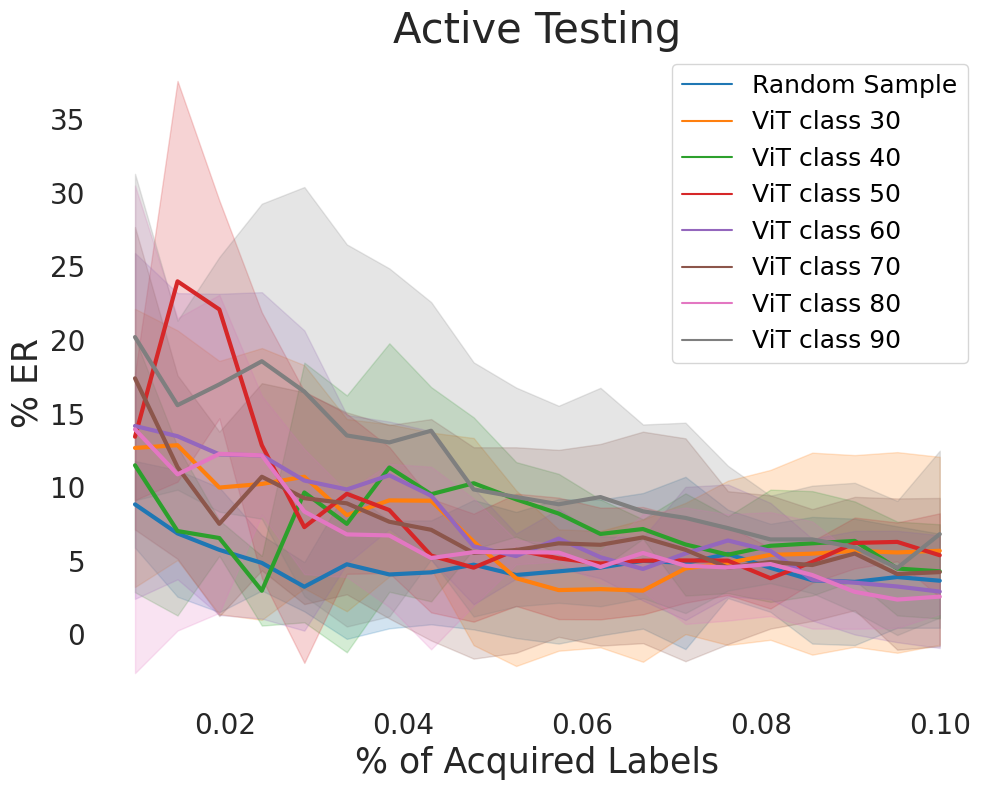

In [18]:
# 16x16, different number of ordinal class
method_dict = {"random sample": "Random Sample", "ViT region": "ViT class 50", "ViT class 30": "ViT class 30", "ViT class 40": "ViT class 40",
              "ViT class 60": "ViT class 60", "ViT class 70": "ViT class 70", "ViT class 80": "ViT class 80", "ViT class 90": "ViT class 90"}
model_dataset = "UNet_VOC"
base_path = f"./pro_data/{model_dataset}/val/"
sample_size_threshold = np_read(base_path + "region_16_16_true_losses.npy").shape[0]
result_json_path = f"./results/previous/{model_dataset}/region_16_16_active_testing/"
true_loss_estimation_path = result_json_path + "None.json"
test_whole_data = read_baseline_data(true_loss_estimation_path)
results = add_entries(result_json_path + "random_sample_3_runs.json")

results =  results.append(add_entries(result_json_path + "ViT_UNet_VOC_class_30_runs_10000.json"),ignore_index=True)
results =  results.append(add_entries(result_json_path + "ViT_UNet_VOC_class_40_runs_10000.json"),ignore_index=True)
results =  results.append(add_entries(result_json_path + "ViT_range_region_runs_10000.json"),ignore_index=True)
results =  results.append(add_entries(result_json_path + "ViT_UNet_VOC_class_60_runs_10000.json"),ignore_index=True)
results =  results.append(add_entries(result_json_path + "ViT_UNet_VOC_class_70_runs_10000.json"),ignore_index=True)
results =  results.append(add_entries(result_json_path + "ViT_UNet_VOC_class_80_runs_10000.json"),ignore_index=True)
results =  results.append(add_entries(result_json_path + "ViT_UNet_VOC_class_90_runs_10000.json"),ignore_index=True)
plot_all_diff_precentage_figure(results, test_whole_data, sample_size_threshold, "loss", x_label_name = "% of Acquired Labels")

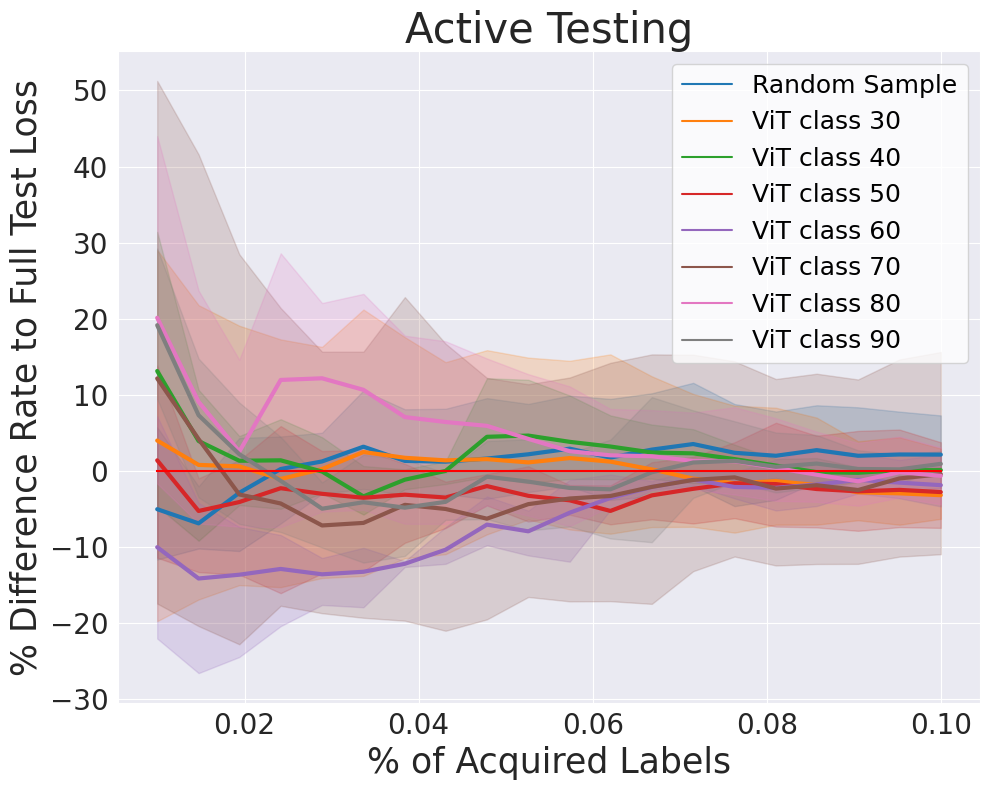

In [10]:
method_dict = {"random sample": "Random Sample", "ViT region": "ViT class 50", "ViT class 30": "ViT class 30", "ViT class 40": "ViT class 40",
              "ViT class 60": "ViT class 60", "ViT class 70": "ViT class 70", "ViT class 80": "ViT class 80", "ViT class 90": "ViT class 90"}
model_dataset = "UNet_VOC"
base_path = f"./pro_data/{model_dataset}/val/"
sample_size_threshold = np_read(base_path + "region_16_16_true_losses.npy").shape[0]
result_json_path = f"./results/{model_dataset}/region_16_16_active_testing/"
true_loss_estimation_path = result_json_path + "None.json"
test_whole_data = read_baseline_data(true_loss_estimation_path)
results = add_entries(result_json_path + "random_sample_3_runs.json")

results =  results.append(add_entries(result_json_path + "ViT_UNet_VOC_class_30_runs_20000.json"),ignore_index=True)
results =  results.append(add_entries(result_json_path + "ViT_UNet_VOC_class_40_runs_20000.json"),ignore_index=True)
results =  results.append(add_entries(result_json_path + "ViT_range_region_runs_20000.json"),ignore_index=True)
results =  results.append(add_entries(result_json_path + "ViT_UNet_VOC_class_60_runs_20000.json"),ignore_index=True)
results =  results.append(add_entries(result_json_path + "ViT_UNet_VOC_class_70_runs_20000.json"),ignore_index=True)
results =  results.append(add_entries(result_json_path + "ViT_UNet_VOC_class_80_runs_20000.json"),ignore_index=True)
results =  results.append(add_entries(result_json_path + "ViT_UNet_VOC_class_90_runs_20000.json"),ignore_index=True)
plot_all_diff_precentage_figure(results, test_whole_data, sample_size_threshold, "loss", x_label_name = "% of Acquired Labels")